In [21]:
import random
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim

In [22]:
# Network (now predicts only the median)
class NextStateMedianNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(NextStateMedianNetwork, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, state_dim)  # Single output per state dim

    def forward(self, state, action):
        if len(state.shape) == 1:
            x = torch.cat((action, state))
        else:
            x = torch.cat((action, state), dim=1) # .unsqueeze(1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

def quantile_loss_median(predicted, target):
    error = target - predicted
    quantile = torch.tensor(0.5)
    loss = torch.max(
        quantile * error,
        (quantile - 1) * error
    )
    return loss.mean()

def mse_loss(predicted, target):
    error = target - predicted
    return error.pow(2).mean()
    

Test where I removed the quadratic part, need to put the threshold back to 1 to back to standard.

In [23]:
class NextStateQuantileNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, num_quantiles):
        super(NextStateQuantileNetwork, self).__init__()
        self.num_quantiles = num_quantiles

        # Input layer (state + action concatenation)
        self.layer1 = nn.Linear(state_dim + action_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, state_dim * num_quantiles)  # Output quantiles for each state dimension
        # self.layer3 = torch.tanh(256, state_dim * num_quantiles)  # Output quantiles for each state dimension

    def forward(self, state, action):
        # Concatenate state and action
        # x = torch.cat((action, state))
        # print("action ", action, "\n")
        
        # print("state ", state, "\n")
        # print("state.shape ", state.shape, "\n")
        # print("action ", action, "\n")
        # print("action.shape ", action.shape, "\n")
        
        if len(state.shape) == 1:
            x = torch.cat((action, state))
        else:
            x = torch.cat((action, state), dim=1) # .unsqueeze(1)
            
        # print("x ", x, "\n")
        # print("x.shape ", x.shape, "\n")
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x.view(-1, self.num_quantiles, state.size(-1))


def quantile_huber_loss(predicted, target, quantiles, batch_size=32):
    """
    Calculate Quantile Huber Loss.
    :param predicted: Predicted quantiles, shape (batch_size, state_dim, num_quantiles)
    :param target: Target next state, shape (batch_size, state_dim)
    :param quantiles: Quantiles (e.g., [0.1, 0.3, 0.7, 0.9]), shape (num_quantiles,)
    """
    
    # print("target.shape ", target.shape, "\n")
    # print("target ", target, "\n")
    # target = target.unsqueeze(-1)  # Shape: (batch_size, state_dim, 1)
    target = target.unsqueeze(1).repeat(1,len(quantiles),1)
    # print("target ", target, "\n")
    # print("predicted ", predicted, "\n")
    # print("target.shape ", target.shape, "\n")
    # print("predicted.shape ", predicted.shape, "\n")
    
    error = target - predicted  # Shape: (batch_size, state_dim, num_quantiles)
    
    # print("error ", error, "\n")
    quantiles = quantiles.view(1, -1, 1)
    quantiles = quantiles.repeat(batch_size, 1, target.shape[-1])  # Shape: [3, 4, 2]
    # quantiles = quantiles.repeat(batch_size, target.shape[-1], 1) 
    # quantiles = quantiles.transpose(1, 2)  # Shape: [3, 2, 4]
    # print("quantiles ", quantiles, "\n")
    
    # # Make delta adaptive by scaling it based on quantiles
    # delta = 1.0
    # adaptive_delta = delta * (1.0 + torch.abs(quantiles - 0.5))  # Give more tolerance to extreme quantiles
    
    # # print("quantiles.shape ", quantiles.shape, "\n")
    # # Calculate loss
    # huber_loss = torch.where(
    #     error.abs() <= 0.0, # 1.0
    #     0.5 * error.pow(2),
    #     error.abs() - 0.5
    # )

    # # huber_loss = error.abs()-0.5  # Simple L1 loss
    
    # # print("huber_loss ", huber_loss, "\n")
    # # print("huber_loss.shape ", huber_loss.shape, "\n")
    
    # # Quantile loss computation
    # quantile_loss = (quantiles - (error < 0).float()).abs() * huber_loss

    # Standard Quantile Loss (Pinball Loss)
    quantile_loss = torch.max(
        quantiles * error,
        (quantiles - 1) * error
    )

    return quantile_loss.mean()

    # Quantile loss computation
    # quantile_loss = torch.abs(quantiles - (error.detach() < 0).float()) * huber_loss
    # return quantile_loss.sum(dim=1).mean()

# def quantile_huber_loss(predicted, target, quantiles, batch_size=32):
#     """
#     Calculate Quantile Huber Loss.
#     :param predicted: Predicted quantiles, shape (batch_size, state_dim, num_quantiles)
#     :param target: Target next state, shape (batch_size, state_dim)
#     :param quantiles: Quantiles (e.g., [0.1, 0.3, 0.7, 0.9]), shape (num_quantiles,)
#     """
    
#     # print("target.shape ", target.shape, "\n")
#     # print("target ", target, "\n")
#     # target = target.unsqueeze(-1)  # Shape: (batch_size, state_dim, 1)
#     target = target.unsqueeze(1).repeat(1,len(quantiles),1)
#     print("target ", target, "\n")
#     print("predicted ", predicted, "\n")
#     print("target.shape ", target.shape, "\n")
#     print("predicted.shape ", predicted.shape, "\n")
    
#     error = target - predicted  # Shape: (batch_size, state_dim, num_quantiles)
    
#     # print("error ", error, "\n")
#     quantiles = quantiles.view(1, -1, 1)
#     quantiles = quantiles.repeat(batch_size, 1, target.shape[-1])  # Shape: [3, 4, 2]
#     # quantiles = quantiles.repeat(batch_size, target.shape[-1], 1) 
#     # quantiles = quantiles.transpose(1, 2)  # Shape: [3, 2, 4]
#     print("quantiles ", quantiles, "\n")
    
#     # print("quantiles.shape ", quantiles.shape, "\n")
#     # Calculate loss
#     huber_loss = torch.where(
#         error.abs() <= 1.0,
#         0.5 * error.pow(2),
#         error.abs() - 0.5
#     )
    
#     # print("huber_loss ", huber_loss, "\n")
#     # print("huber_loss.shape ", huber_loss.shape, "\n")
    
#     # Quantile loss computation
#     # quantile_loss = (quantiles - (error < 0).float()).abs() * huber_loss
#     # return quantile_loss.mean()

#     # Quantile loss computation
#     quantile_loss = torch.abs(quantiles - (error.detach() < 0).float()) * huber_loss
#     return quantile_loss.sum(dim=1).mean()


Graph of number of values below the different quantiles graph and calculation functions


In [24]:
def plot_nb_below_quantiles(prob, nb_belowq1_list, nb_belowq2_list, nb_belowq3_list, nb_belowq4_list, nb_belowq5_list, nb_belowq6_list, nb_belowq7_list, nb_belowq8_list, nb_belowq9_list, nb_belowq10_list, variable):
    
    var = variable
    
    if variable == "theta":
        variable = r"$\theta$"
    if variable == "omega":
        variable = r"$\omega$"
    if variable == "costheta1":
        variable = r"$\cos(\theta_1)$"
    if variable == "sintheta1":
        variable = r"$\sin(\theta_1)$"
    if variable == "costheta2":
        variable = r"$\cos(\theta_2)$"
    if variable == "sintheta2":
        variable = r"$\sin(\theta_2)$"
    

    plt.figure(1)
    # plt.plot(nb_belowq1_list, label=f'quantile1_{variable}')
    # plt.plot(nb_belowq2_list, label=f'quantile2_{variable}')
    # plt.plot(nb_belowq3_list, label=f'quantile3_{variable}')
    # plt.plot(nb_belowq4_list, label=f'quantile4_{variable}')
    # plt.plot(nb_belowq5_list, label=f'quantile5_{variable}')
    # plt.plot(nb_belowq6_list, label=f'quantile6_{variable}')
    # plt.plot(nb_belowq7_list, label=f'quantile7_{variable}')
    # plt.plot(nb_belowq8_list, label=f'quantile8_{variable}')
    # plt.plot(nb_belowq9_list, label=f'quantile9_{variable}')
    # plt.plot(nb_belowq10_list, label=f'quantile10_{variable}')
    plt.plot(nb_belowq1_list, label=f'Q1_{variable}')
    plt.plot(nb_belowq2_list, label=f'Q2_{variable}')
    plt.plot(nb_belowq3_list, label=f'Q3_{variable}')
    plt.plot(nb_belowq4_list, label=f'Q4_{variable}')
    plt.plot(nb_belowq5_list, label=f'Q5_{variable}')
    plt.plot(nb_belowq6_list, label=f'Q6_{variable}')
    plt.plot(nb_belowq7_list, label=f'Q7_{variable}')
    plt.plot(nb_belowq8_list, label=f'Q8_{variable}')
    plt.plot(nb_belowq9_list, label=f'Q9_{variable}')
    plt.plot(nb_belowq10_list, label=f'Q10_{variable}')
    plt.hlines(0.1, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile1'
    plt.hlines(0.2, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile2'
    plt.hlines(0.3, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile3'
    plt.hlines(0.4, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile4'
    plt.hlines(0.5, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile5'
    plt.hlines(0.6, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile6'
    plt.hlines(0.7, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile7'
    plt.hlines(0.8, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile8'
    plt.hlines(0.9, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile9'
    plt.hlines(1.0, 0, len(nb_belowq1_list), colors='r', linestyles='dashed') # , label='quantile10'
    plt.xlabel('Number of steps')
    # plt.ylabel(f'Percentage of steps with $s_{{env}} < s_{{quantile{variable}}}$')
    plt.ylabel(f'Percentage of steps with env \n prediction below quantile {variable} prediction')
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    plt.savefig(f'{prob}_quantile_{var}_below.png', bbox_inches='tight')
    # plt.savefig(f'{prob}_quantile_{var}_below.png', bbox_inches='tight')

    

In [25]:
def nb_below_quantile(env, quantile0, quantile1, quantile2, quantile3, quantile4, quantile5, quantile6, quantile7, quantile8, quantile9, quantile10):
    
    nb_belowq1 = 0
    nb_belowq2 = 0
    nb_belowq3 = 0
    nb_belowq4 = 0
    nb_belowq5 = 0
    nb_belowq6 = 0
    nb_belowq7 = 0
    nb_belowq8 = 0
    nb_belowq9 = 0
    nb_belowq10 = 0
    
    nb_belowq1_list = [0]
    nb_belowq2_list = [0]
    nb_belowq3_list = [0]
    nb_belowq4_list = [0]
    nb_belowq5_list = [0]
    nb_belowq6_list = [0]
    nb_belowq7_list = [0]
    nb_belowq8_list = [0]
    nb_belowq9_list = [0]
    nb_belowq10_list = [0]
    
    
    for i in range(len(quantile0)):
        
        if env[i] < quantile1[i]:
            nb_belowq1 += 1
            
        if env[i] < quantile2[i]:
            nb_belowq2 += 1
            
        if env[i] < quantile3[i]:
            nb_belowq3 += 1
            
        if env[i] < quantile4[i]:
            nb_belowq4 += 1
            
        if env[i] < quantile5[i]:
            nb_belowq5 += 1
            
        if env[i] < quantile6[i]:
            nb_belowq6 += 1
            
        if env[i] < quantile7[i]:
            nb_belowq7 += 1
            
        if env[i] < quantile8[i]:
            nb_belowq8 += 1
            
        if env[i] < quantile9[i]:
            nb_belowq9 += 1
            
        if env[i] < quantile10[i]:
            nb_belowq10 += 1

        nb_belowq1_list.append(nb_belowq1/(i+1))
        nb_belowq2_list.append(nb_belowq2/(i+1))
        nb_belowq3_list.append(nb_belowq3/(i+1))
        nb_belowq4_list.append(nb_belowq4/(i+1))
        nb_belowq5_list.append(nb_belowq5/(i+1))
        nb_belowq6_list.append(nb_belowq6/(i+1))
        nb_belowq7_list.append(nb_belowq7/(i+1))
        nb_belowq8_list.append(nb_belowq8/(i+1))
        nb_belowq9_list.append(nb_belowq9/(i+1))
        nb_belowq10_list.append(nb_belowq10/(i+1))
        
        

    return nb_belowq1_list, nb_belowq2_list, nb_belowq3_list, nb_belowq4_list, nb_belowq5_list, nb_belowq6_list, nb_belowq7_list, nb_belowq8_list, nb_belowq9_list, nb_belowq10_list


## Acrobot

In [26]:
prob = "Acrobot"

When taking a step in the env, the state variables are $\cos{(\theta_1)}, \sin{(\theta_1)}, \cos{(\theta_2)}, \sin{(\theta_2)}, \omega_1, \omega_2$.

When using env.state, we have $\theta_1, \theta_2, \omega_1, \omega_2$. This allows us to have more precision in the angles which is needed in the MPC cost function.

Trying different PF and pre-trained using rnd actions QRNN - Feb 5


- Train on randomly sampled actions

In [27]:
error_magnitudes_costheta1 = []
error_magnitudes_sintheta1 = []
error_magnitudes_costheta2 = []
error_magnitudes_sintheta2 = []
error_magnitudes_omega1 = []
error_magnitudes_omega2 = []

env_costheta1 = []
env_sintheta1 = []
env_costheta2 = []
env_sintheta2 = []
env_omega1 = []
env_omega2 = []

pred_costheta1 = []
pred_sintheta1 = []
pred_costheta2 = []
pred_sintheta2 = []
pred_omega1 = []
pred_omega2 = []

actions_list_episode = []
actions_list_all = []
rewards_list = []

# quantile 0 data
quantile0_costheta1 = []
quantile0_sintheta1 = []
quantile0_costheta2 = []
quantile0_sintheta2 = []
quantile0_omega1 = []
quantile0_omega2 = []

# quantile 1 data
quantile1_costheta1 = []
quantile1_sintheta1 = []
quantile1_costheta2 = []
quantile1_sintheta2 = []
quantile1_omega1 = []
quantile1_omega2 = []

# quantile 2 data
quantile2_costheta1 = []
quantile2_sintheta1 = []
quantile2_costheta2 = []
quantile2_sintheta2 = []
quantile2_omega1 = []
quantile2_omega2 = []

# quantile 3 data
quantile3_costheta1 = []
quantile3_sintheta1 = []
quantile3_costheta2 = []
quantile3_sintheta2 = []
quantile3_omega1 = []
quantile3_omega2 = []

# quantile 4 data
quantile4_costheta1 = []
quantile4_sintheta1 = []
quantile4_costheta2 = []
quantile4_sintheta2 = []
quantile4_omega1 = []
quantile4_omega2 = []

# quantile 5 data
quantile5_costheta1 = []
quantile5_sintheta1 = []
quantile5_costheta2 = []
quantile5_sintheta2 = []
quantile5_omega1 = []
quantile5_omega2 = []

# quantile 6 data
quantile6_costheta1 = []
quantile6_sintheta1 = []
quantile6_costheta2 = []
quantile6_sintheta2 = []
quantile6_omega1 = []
quantile6_omega2 = []

# quantile 7 data
quantile7_costheta1 = []
quantile7_sintheta1 = []
quantile7_costheta2 = []
quantile7_sintheta2 = []
quantile7_omega1 = []
quantile7_omega2 = []

# quantile 8 data
quantile8_costheta1 = []
quantile8_sintheta1 = []
quantile8_costheta2 = []
quantile8_sintheta2 = []
quantile8_omega1 = []
quantile8_omega2 = []

# quantile 9 data
quantile9_costheta1 = []
quantile9_sintheta1 = []
quantile9_costheta2 = []
quantile9_sintheta2 = []
quantile9_omega1 = []
quantile9_omega2 = []

# quantile 10 data
quantile10_costheta1 = []
quantile10_sintheta1 = []
quantile10_costheta2 = []
quantile10_sintheta2 = []
quantile10_omega1 = []
quantile10_omega2 = []

seed = 0
env = gym.make('Acrobot-v1').unwrapped
sim_env = gym.make('Acrobot-v1').unwrapped  # Additional simulation model for MPC
# max_episode_steps = 500
# env = gym.make('CartPole-v1').unwrapped
# sim_env = gym.make('CartPole-v1').unwrapped  # Additional simulation model for MPC
sim_env.reset(seed=seed)
env.reset(seed=seed)

# Hyperparameters
state_dim = env.observation_space.shape[0] #-2#-1 # Since we only care about angle and omega which are given using env.state
# action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
action_dim=1
# Define your quantiles (e.g., 0.1, 0.3, 0.7, 0.9)
# quantiles = torch.tensor([0.1, 0.3, 0.7, 0.9], dtype=torch.float32)
quantiles = torch.tensor(np.array([0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), dtype=torch.float32)

# num_quantiles = 4  # Example with 4 quantiles
num_quantiles = len(quantiles)

# Initialize the Next-State Prediction Network
model = NextStateQuantileNetwork(state_dim, action_dim, num_quantiles)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Experience replay buffer
replay_buffer = []

batch_size = 32
num_test_steps = 20000

state, _ = env.reset(seed=seed)
episode_reward = 0
actions_list = []
done = False
truncated = False

states_low = torch.tensor([-1, -1, -1, -1, -12.566371, -28.274334])
states_high = torch.tensor([1, 1, 1, 1, 12.566371, 28.274334])
actions_taken = np.zeros(num_test_steps)

env.action_space.seed(seed)

for step in range(num_test_steps):
    # state = env.state
    action = env.action_space.sample()
    actions_taken[step] = action
    
    # Apply the first action from the optimized sequence
    next_state, reward, done, truncated, info = env.step(action)
    # next_state = env.state
    episode_reward += reward
    actions_list.append(action)
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        # test_next_state = torch.clip(test_next_state, states_low, states_high)
        # print("test_next_state ", test_next_state, "\n")
        
        test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        test_state = torch.clip(test_state, states_low, states_high)
        
        # Predict next state quantiles
        predicted_quantiles = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_costheta1 = np.append(pred_costheta1, mid_quantile[0][0])
        pred_sintheta1 = np.append(pred_sintheta1, mid_quantile[0][1])
        pred_costheta2 = np.append(pred_costheta2, mid_quantile[0][2]) 
        pred_sintheta2 = np.append(pred_sintheta2, mid_quantile[0][3])
        pred_omega1 = np.append(pred_omega1, mid_quantile[0][4])
        pred_omega2 = np.append(pred_omega2, mid_quantile[0][5])
        
        ########################
        
        # Quantile 0 data
        quantile0_costheta1 = np.append(quantile0_costheta1, predicted_quantiles[0][0][0].item())
        quantile0_sintheta1 = np.append(quantile0_sintheta1, predicted_quantiles[0][0][1].item())
        quantile0_costheta2 = np.append(quantile0_costheta2, predicted_quantiles[0][0][2].item())
        quantile0_sintheta2 = np.append(quantile0_sintheta2, predicted_quantiles[0][0][3].item())
        quantile0_omega1 = np.append(quantile0_omega1, predicted_quantiles[0][0][4].item())
        quantile0_omega2 = np.append(quantile0_omega2, predicted_quantiles[0][0][5].item())
        
        # Quantile 1 data
        quantile1_costheta1 = np.append(quantile1_costheta1, predicted_quantiles[0][1][0].item())
        quantile1_sintheta1 = np.append(quantile1_sintheta1, predicted_quantiles[0][1][1].item())
        quantile1_costheta2 = np.append(quantile1_costheta2, predicted_quantiles[0][1][2].item())
        quantile1_sintheta2 = np.append(quantile1_sintheta2, predicted_quantiles[0][1][3].item())
        quantile1_omega1 = np.append(quantile1_omega1, predicted_quantiles[0][1][4].item())
        quantile1_omega2 = np.append(quantile1_omega2, predicted_quantiles[0][1][5].item())
        
        # Quantile 2 data
        quantile2_costheta1 = np.append(quantile2_costheta1, predicted_quantiles[0][2][0].item())
        quantile2_sintheta1 = np.append(quantile2_sintheta1, predicted_quantiles[0][2][1].item())
        quantile2_costheta2 = np.append(quantile2_costheta2, predicted_quantiles[0][2][2].item())
        quantile2_sintheta2 = np.append(quantile2_sintheta2, predicted_quantiles[0][2][3].item())
        quantile2_omega1 = np.append(quantile2_omega1, predicted_quantiles[0][2][4].item())
        quantile2_omega2 = np.append(quantile2_omega2, predicted_quantiles[0][2][5].item())
        
        # Quantile 3 data
        quantile3_costheta1 = np.append(quantile3_costheta1, predicted_quantiles[0][3][0].item())
        quantile3_sintheta1 = np.append(quantile3_sintheta1, predicted_quantiles[0][3][1].item())
        quantile3_costheta2 = np.append(quantile3_costheta2, predicted_quantiles[0][3][2].item())
        quantile3_sintheta2 = np.append(quantile3_sintheta2, predicted_quantiles[0][3][3].item())
        quantile3_omega1 = np.append(quantile3_omega1, predicted_quantiles[0][3][4].item())
        quantile3_omega2 = np.append(quantile3_omega2, predicted_quantiles[0][3][5].item())
        
        # Quantile 4 data
        quantile4_costheta1 = np.append(quantile4_costheta1, predicted_quantiles[0][4][0].item())
        quantile4_sintheta1 = np.append(quantile4_sintheta1, predicted_quantiles[0][4][1].item())
        quantile4_costheta2 = np.append(quantile4_costheta2, predicted_quantiles[0][4][2].item())
        quantile4_sintheta2 = np.append(quantile4_sintheta2, predicted_quantiles[0][4][3].item())
        quantile4_omega1 = np.append(quantile4_omega1, predicted_quantiles[0][4][4].item())
        quantile4_omega2 = np.append(quantile4_omega2, predicted_quantiles[0][4][5].item())
        
        # Quantile 5 data
        quantile5_costheta1 = np.append(quantile5_costheta1, predicted_quantiles[0][5][0].item())
        quantile5_sintheta1 = np.append(quantile5_sintheta1, predicted_quantiles[0][5][1].item())
        quantile5_costheta2 = np.append(quantile5_costheta2, predicted_quantiles[0][5][2].item())
        quantile5_sintheta2 = np.append(quantile5_sintheta2, predicted_quantiles[0][5][3].item())
        quantile5_omega1 = np.append(quantile5_omega1, predicted_quantiles[0][5][4].item())
        quantile5_omega2 = np.append(quantile5_omega2, predicted_quantiles[0][5][5].item())
        
        # Quantile 6 data
        quantile6_costheta1 = np.append(quantile6_costheta1, predicted_quantiles[0][6][0].item())
        quantile6_sintheta1 = np.append(quantile6_sintheta1, predicted_quantiles[0][6][1].item())
        quantile6_costheta2 = np.append(quantile6_costheta2, predicted_quantiles[0][6][2].item())
        quantile6_sintheta2 = np.append(quantile6_sintheta2, predicted_quantiles[0][6][3].item())
        quantile6_omega1 = np.append(quantile6_omega1, predicted_quantiles[0][6][4].item())
        quantile6_omega2 = np.append(quantile6_omega2, predicted_quantiles[0][6][5].item())
        
        # Quantile 7 data
        quantile7_costheta1 = np.append(quantile7_costheta1, predicted_quantiles[0][7][0].item())
        quantile7_sintheta1 = np.append(quantile7_sintheta1, predicted_quantiles[0][7][1].item())
        quantile7_costheta2 = np.append(quantile7_costheta2, predicted_quantiles[0][7][2].item())
        quantile7_sintheta2 = np.append(quantile7_sintheta2, predicted_quantiles[0][7][3].item())
        quantile7_omega1 = np.append(quantile7_omega1, predicted_quantiles[0][7][4].item())
        quantile7_omega2 = np.append(quantile7_omega2, predicted_quantiles[0][7][5].item())
        
        # Quantile 8 data
        quantile8_costheta1 = np.append(quantile8_costheta1, predicted_quantiles[0][8][0].item())
        quantile8_sintheta1 = np.append(quantile8_sintheta1, predicted_quantiles[0][8][1].item())
        quantile8_costheta2 = np.append(quantile8_costheta2, predicted_quantiles[0][8][2].item())
        quantile8_sintheta2 = np.append(quantile8_sintheta2, predicted_quantiles[0][8][3].item())
        quantile8_omega1 = np.append(quantile8_omega1, predicted_quantiles[0][8][4].item())
        quantile8_omega2 = np.append(quantile8_omega2, predicted_quantiles[0][8][5].item())
        
        # Quantile 9 data
        quantile9_costheta1 = np.append(quantile9_costheta1, predicted_quantiles[0][9][0].item())
        quantile9_sintheta1 = np.append(quantile9_sintheta1, predicted_quantiles[0][9][1].item())
        quantile9_costheta2 = np.append(quantile9_costheta2, predicted_quantiles[0][9][2].item())
        quantile9_sintheta2 = np.append(quantile9_sintheta2, predicted_quantiles[0][9][3].item())
        quantile9_omega1 = np.append(quantile9_omega1, predicted_quantiles[0][9][4].item())
        quantile9_omega2 = np.append(quantile9_omega2, predicted_quantiles[0][9][5].item())
        
        # Quantile 10 data
        quantile10_costheta1 = np.append(quantile10_costheta1, predicted_quantiles[0][10][0].item())
        quantile10_sintheta1 = np.append(quantile10_sintheta1, predicted_quantiles[0][10][1].item())
        quantile10_costheta2 = np.append(quantile10_costheta2, predicted_quantiles[0][10][2].item())
        quantile10_sintheta2 = np.append(quantile10_sintheta2, predicted_quantiles[0][10][3].item())
        quantile10_omega1 = np.append(quantile10_omega1, predicted_quantiles[0][10][4].item())
        quantile10_omega2 = np.append(quantile10_omega2, predicted_quantiles[0][10][5].item())
        
        ########################
                
        # deltatheta1 = test_next_state[0] - mid_quantile[0][0]
        # deltatheta2 = test_next_state[1] - mid_quantile[0][1]
        # deltaomega1 = test_next_state[2] - mid_quantile[0][2]
        # deltaomega2 = test_next_state[3] - mid_quantile[0][3]
        deltacostheta1 = test_next_state[0] - mid_quantile[0][0]
        deltasintheta1 = test_next_state[1] - mid_quantile[0][1]
        deltacostheta2 = test_next_state[2] - mid_quantile[0][2]
        deltasintheta2 = test_next_state[3] - mid_quantile[0][3]
        deltaomega1 = test_next_state[4] - mid_quantile[0][4]
        deltaomega2 = test_next_state[5] - mid_quantile[0][5]

        # delta = env_test_state - mean_next_state.flatten()#.detach().numpy()
        # print("delta ", delta, "\n") # 6
        # print("delta_x ", deltax, "\n") # 7
        # error_magnitude = np.linalg.norm(delta)
        # error_magnitudes.append(error_magnitude)
        error_magnitudes_costheta1.append(np.abs(deltacostheta1.detach().numpy())) # .detach().numpy()
        error_magnitudes_sintheta1.append(np.abs(deltasintheta1.detach().numpy())) # .detach().numpy()
        error_magnitudes_costheta2.append(np.abs(deltacostheta2.detach().numpy())) # .detach().numpy()
        error_magnitudes_sintheta2.append(np.abs(deltasintheta2.detach().numpy())) # .detach().numpy()
        error_magnitudes_omega1.append(np.abs(deltaomega1.detach().numpy())) # .detach().numpy()
        error_magnitudes_omega2.append(np.abs(deltaomega2.detach().numpy())) # .detach().numpy()
        # env_next_states.append(env_test_state)
        env_costheta1.append(test_next_state[0])
        env_sintheta1.append(test_next_state[1])
        env_costheta2.append(test_next_state[2])
        env_sintheta2.append(test_next_state[3])
        env_omega1.append(test_next_state[4])
        env_omega2.append(test_next_state[5])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    replay_buffer.append((state, np.array([action]), reward, next_state, done))
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        
        states = torch.clip(states, states_low, states_high)
        
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # Compute Quantile Huber Loss
        loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)

        
        # Compute Quantile Huber Loss
        loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    state = next_state
    
    if done or truncated:
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        actions_list = []
        done = False
        truncated = False


Plots for the acrobot env when using cos(theta1), sin(theta1), cos(theta2), sin(theta2), omega1, omega2


In [28]:
# # # Plot training results
# # import matplotlib.pyplot as plt
# # # Plot the rewards
# # plt.figure(1)
# # # plt.legend()
# # # plt.grid()
# # plt.plot(episode_reward_list)
# # plt.xlabel('Nb of episodes')
# # plt.ylabel('episode reward')
# # # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')
# # # plt.yscale('log')

# plt.figure(2)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_theta1)
# plt.ylabel('error_magnitudes_theta1')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
# plt.yscale('log')

# plt.figure(3)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_theta2)
# plt.ylabel('error_magnitudes_theta2')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(4)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_omega1)
# plt.ylabel('error_magnitudes_omega1')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
# plt.yscale('log')

# plt.figure(5)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_omega2)
# plt.ylabel('error_magnitudes_omega2')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(6)
# plt.xlabel('Nb of steps')
# plt.ylabel('x comparison between env and QRNN')
# plt.plot(env_theta1, label='env_next_states')
# plt.plot(pred_theta1, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_theta1)), pred_theta1 - pred_theta1_bottom_1std, pred_theta1 + pred_theta1_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_theta1)), pred_theta1 - pred_theta1_bottom_2std, pred_theta1 + pred_theta1_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(7)
# plt.xlabel('Nb of steps')
# plt.ylabel('v comparison between env and QRNN')
# plt.plot(env_theta2, label='env_next_states')
# plt.plot(pred_theta2, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_theta2)), pred_theta2 - pred_theta2_bottom_1std, pred_theta2 + pred_theta2_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_theta2)), pred_theta2 - pred_theta2_bottom_2std, pred_theta2 + pred_theta2_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(8)
# plt.xlabel('Nb of steps')
# plt.ylabel('theta comparison between env and QRNN')
# plt.plot(env_omega1, label='env_next_states')
# plt.plot(pred_omega1, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_omega1)), pred_omega1 - pred_omega1_bottom_1std, pred_omega1 + pred_omega1_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_omega1)), pred_omega1 - pred_omega1_bottom_2std, pred_omega1 + pred_omega1_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(9)
# plt.xlabel('Nb of steps')
# plt.ylabel('omega comparison between env and QRNN')
# plt.plot(env_omega2, label='env_next_states')
# plt.plot(pred_omega2, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_omega2)), pred_omega2 - pred_omega2_bottom_1std, pred_omega2 + pred_omega2_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_omega2)), pred_omega2 - pred_omega2_bottom_2std, pred_omega2 + pred_omega2_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()




Graph of the number of values below the different quantiles


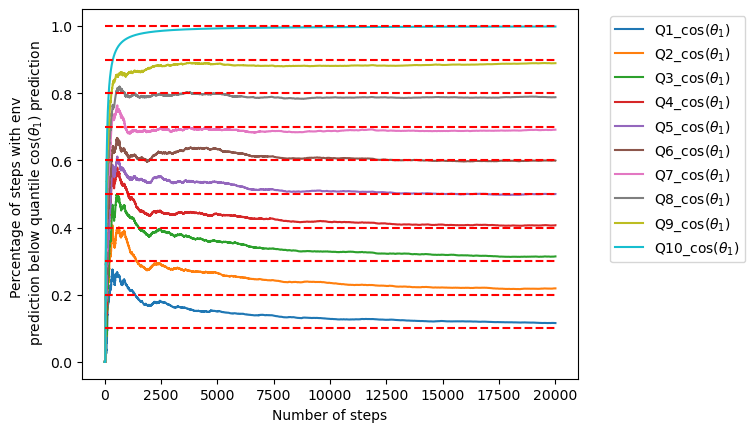

In [29]:
# costheta1
variable = 'costheta1'
nb_belowq1_list_costheta1, nb_belowq2_list_costheta1, nb_belowq3_list_costheta1, nb_belowq4_list_costheta1, nb_belowq5_list_costheta1, nb_belowq6_list_costheta1, nb_belowq7_list_costheta1, nb_belowq8_list_costheta1, nb_belowq9_list_costheta1, nb_belowq10_list_costheta1 = nb_below_quantile(env_costheta1, quantile0_costheta1, quantile1_costheta1, quantile2_costheta1, quantile3_costheta1, quantile4_costheta1, quantile5_costheta1, quantile6_costheta1, quantile7_costheta1, quantile8_costheta1, quantile9_costheta1, quantile10_costheta1)
plot_nb_below_quantiles(prob, nb_belowq1_list_costheta1, nb_belowq2_list_costheta1, nb_belowq3_list_costheta1, nb_belowq4_list_costheta1, nb_belowq5_list_costheta1, nb_belowq6_list_costheta1, nb_belowq7_list_costheta1, nb_belowq8_list_costheta1, nb_belowq9_list_costheta1, nb_belowq10_list_costheta1, variable)



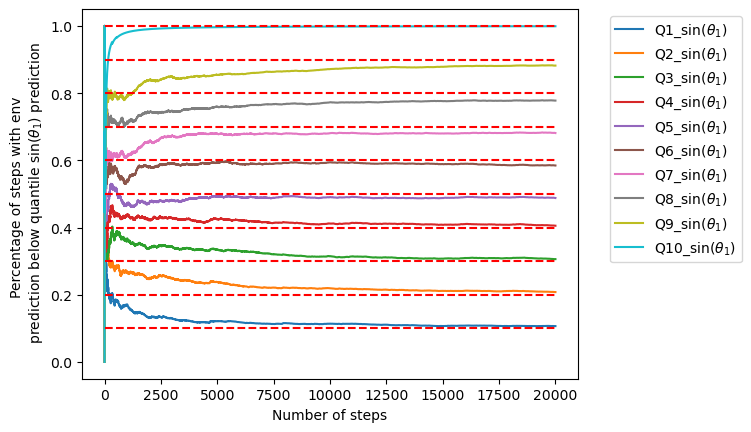

In [30]:
# sintheta1
variable = 'sintheta1'
nb_belowq1_list_sintheta1, nb_belowq2_list_sintheta1, nb_belowq3_list_sintheta1, nb_belowq4_list_sintheta1, nb_belowq5_list_sintheta1, nb_belowq6_list_sintheta1, nb_belowq7_list_sintheta1, nb_belowq8_list_sintheta1, nb_belowq9_list_sintheta1, nb_belowq10_list_sintheta1 = nb_below_quantile(env_sintheta1, quantile0_sintheta1, quantile1_sintheta1, quantile2_sintheta1, quantile3_sintheta1, quantile4_sintheta1, quantile5_sintheta1, quantile6_sintheta1, quantile7_sintheta1, quantile8_sintheta1, quantile9_sintheta1, quantile10_sintheta1)
plot_nb_below_quantiles(prob, nb_belowq1_list_sintheta1, nb_belowq2_list_sintheta1, nb_belowq3_list_sintheta1, nb_belowq4_list_sintheta1, nb_belowq5_list_sintheta1, nb_belowq6_list_sintheta1, nb_belowq7_list_sintheta1, nb_belowq8_list_sintheta1, nb_belowq9_list_sintheta1, nb_belowq10_list_sintheta1, variable)



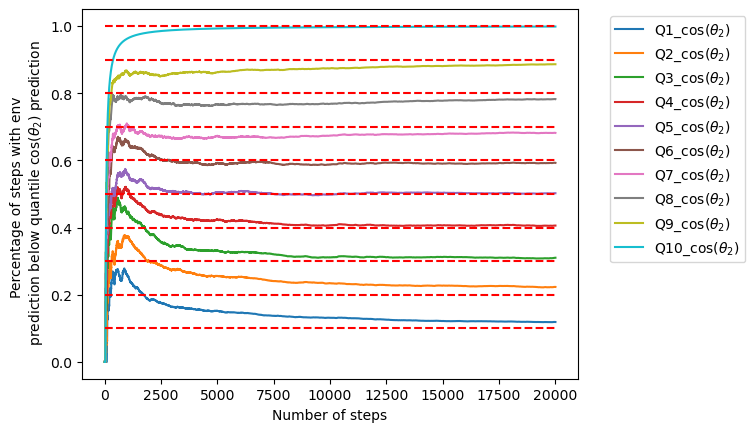

In [31]:
# costheta2
variable = 'costheta2'
nb_belowq1_list_costheta2, nb_belowq2_list_costheta2, nb_belowq3_list_costheta2, nb_belowq4_list_costheta2, nb_belowq5_list_costheta2, nb_belowq6_list_costheta2, nb_belowq7_list_costheta2, nb_belowq8_list_costheta2, nb_belowq9_list_costheta2, nb_belowq10_list_costheta2 = nb_below_quantile(env_costheta2, quantile0_costheta2, quantile1_costheta2, quantile2_costheta2, quantile3_costheta2, quantile4_costheta2, quantile5_costheta2, quantile6_costheta2, quantile7_costheta2, quantile8_costheta2, quantile9_costheta2, quantile10_costheta2)
plot_nb_below_quantiles(prob, nb_belowq1_list_costheta2, nb_belowq2_list_costheta2, nb_belowq3_list_costheta2, nb_belowq4_list_costheta2, nb_belowq5_list_costheta2, nb_belowq6_list_costheta2, nb_belowq7_list_costheta2, nb_belowq8_list_costheta2, nb_belowq9_list_costheta2, nb_belowq10_list_costheta2, variable)


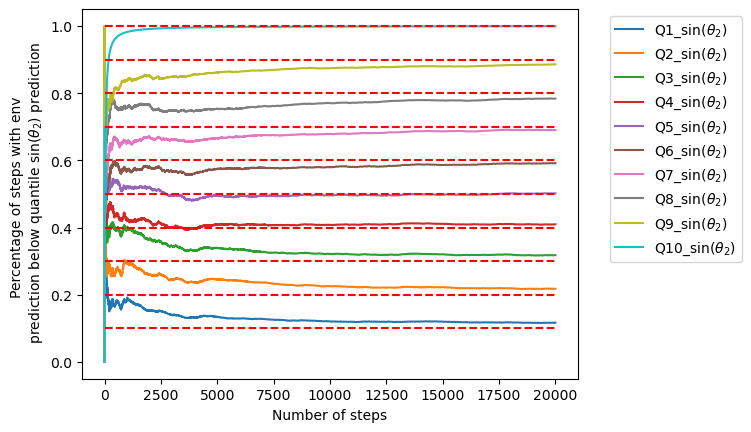

In [32]:
# sintheta2
variable = 'sintheta2'
nb_belowq1_list_sintheta2, nb_belowq2_list_sintheta2, nb_belowq3_list_sintheta2, nb_belowq4_list_sintheta2, nb_belowq5_list_sintheta2, nb_belowq6_list_sintheta2, nb_belowq7_list_sintheta2, nb_belowq8_list_sintheta2, nb_belowq9_list_sintheta2, nb_belowq10_list_sintheta2 = nb_below_quantile(env_sintheta2, quantile0_sintheta2, quantile1_sintheta2, quantile2_sintheta2, quantile3_sintheta2, quantile4_sintheta2, quantile5_sintheta2, quantile6_sintheta2, quantile7_sintheta2, quantile8_sintheta2, quantile9_sintheta2, quantile10_sintheta2)
plot_nb_below_quantiles(prob, nb_belowq1_list_sintheta2, nb_belowq2_list_sintheta2, nb_belowq3_list_sintheta2, nb_belowq4_list_sintheta2, nb_belowq5_list_sintheta2, nb_belowq6_list_sintheta2, nb_belowq7_list_sintheta2, nb_belowq8_list_sintheta2, nb_belowq9_list_sintheta2, nb_belowq10_list_sintheta2, variable)


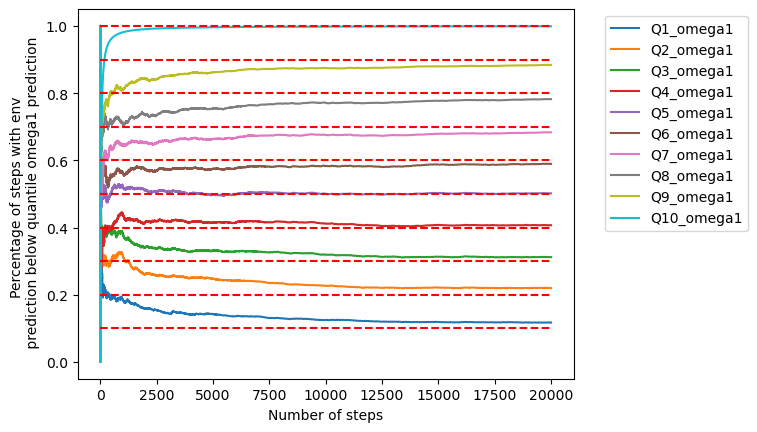

In [33]:
# omega1
variable = 'omega1'
nb_belowq1_list_omega1, nb_belowq2_list_omega1, nb_belowq3_list_omega1, nb_belowq4_list_omega1, nb_belowq5_list_omega1, nb_belowq6_list_omega1, nb_belowq7_list_omega1, nb_belowq8_list_omega1, nb_belowq9_list_omega1, nb_belowq10_list_omega1 = nb_below_quantile(env_omega1, quantile0_omega1, quantile1_omega1, quantile2_omega1, quantile3_omega1, quantile4_omega1, quantile5_omega1, quantile6_omega1, quantile7_omega1, quantile8_omega1, quantile9_omega1, quantile10_omega1)
plot_nb_below_quantiles(prob, nb_belowq1_list_omega1, nb_belowq2_list_omega1, nb_belowq3_list_omega1, nb_belowq4_list_omega1, nb_belowq5_list_omega1, nb_belowq6_list_omega1, nb_belowq7_list_omega1, nb_belowq8_list_omega1, nb_belowq9_list_omega1, nb_belowq10_list_omega1, variable)


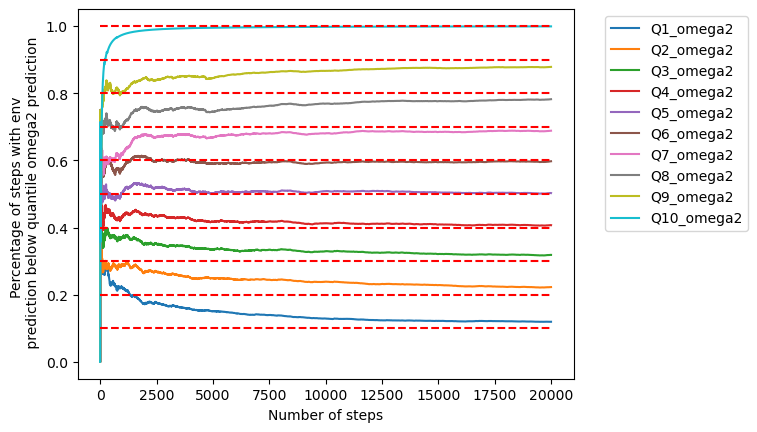

In [34]:
# omega2
variable = 'omega2'
nb_belowq1_list_omega2, nb_belowq2_list_omega2, nb_belowq3_list_omega2, nb_belowq4_list_omega2, nb_belowq5_list_omega2, nb_belowq6_list_omega2, nb_belowq7_list_omega2, nb_belowq8_list_omega2, nb_belowq9_list_omega2, nb_belowq10_list_omega2 = nb_below_quantile(env_omega2, quantile0_omega2, quantile1_omega2, quantile2_omega2, quantile3_omega2, quantile4_omega2, quantile5_omega2, quantile6_omega2, quantile7_omega2, quantile8_omega2, quantile9_omega2, quantile10_omega2)
plot_nb_below_quantiles(prob, nb_belowq1_list_omega2, nb_belowq2_list_omega2, nb_belowq3_list_omega2, nb_belowq4_list_omega2, nb_belowq5_list_omega2, nb_belowq6_list_omega2, nb_belowq7_list_omega2, nb_belowq8_list_omega2, nb_belowq9_list_omega2, nb_belowq10_list_omega2, variable)



## Cart pole

In [35]:
prob = "CartPole"

In [36]:
error_magnitudes_x = []
error_magnitudes_v = []
error_magnitudes_theta = []
error_magnitudes_omega = []

env_x = []
env_v = []
env_theta = []
env_omega = []
pred_x = []
pred_v = []
pred_theta = []
pred_omega = []

# pred_x_var = []
# pred_y_var = []
# pred_z_var = []

pred_x_bottom_1std = []
pred_x_top_1std = []
pred_x_bottom_2std = []
pred_x_top_2std = []
pred_v_bottom_1std = []
pred_v_top_1std = []
pred_v_bottom_2std = []
pred_v_top_2std = []

pred_theta_bottom_1std = []
pred_theta_top_1std = []
pred_theta_bottom_2std = []
pred_theta_top_2std = []
pred_omega_bottom_1std = []
pred_omega_top_1std = []
pred_omega_bottom_2std = []
pred_omega_top_2std = []

actions_list_episode = []
actions_list_all = []
rewards_list = []

# quantile 0 data
quantile0_x = []
quantile0_v = []
quantile0_theta = []
quantile0_omega = []

# quantile 1 data
quantile1_x = []
quantile1_v = []
quantile1_theta = []
quantile1_omega = []

# quantile 2 data
quantile2_x = []
quantile2_v = []
quantile2_theta = []
quantile2_omega = []

# quantile 3 data
quantile3_x = []
quantile3_v = []
quantile3_theta = []
quantile3_omega = []

# quantile 4 data
quantile4_x = []
quantile4_v = []
quantile4_theta = []
quantile4_omega = []

# quantile 5 data
quantile5_x = []
quantile5_v = []
quantile5_theta = []
quantile5_omega = []

# quantile 6 data
quantile6_x = []
quantile6_v = []
quantile6_theta = []
quantile6_omega = []

# quantile 7 data
quantile7_x = []
quantile7_v = []
quantile7_theta = []
quantile7_omega = []

# quantile 8 data
quantile8_x = []
quantile8_v = []
quantile8_theta = []
quantile8_omega = []

# quantile 9 data
quantile9_x = []
quantile9_v = []
quantile9_theta = []
quantile9_omega = []

# quantile 10 data
quantile10_x = []
quantile10_v = []
quantile10_theta = []
quantile10_omega = []

seed = 0
# max_episodes = 100 # 4 #30#00
# max_episode_steps = 200
env = gym.make('CartPole-v0').unwrapped
# sim_env = gym.make('CartPole-v0').unwrapped  # Additional simulation model for MPC
# max_episode_steps = 500
# env = gym.make('CartPole-v1').unwrapped
# sim_env = gym.make('CartPole-v1').unwrapped  # Additional simulation model for MPC
# sim_env.reset(seed=seed)
env.reset(seed=seed)

# Hyperparameters
state_dim = env.observation_space.shape[0]#-1 # Since we only care about angle and omega which are given using env.state
# action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
action_dim=1
# Define your quantiles (e.g., 0.1, 0.3, 0.7, 0.9)
# quantiles = torch.tensor([0.1, 0.3, 0.7, 0.9], dtype=torch.float32)
quantiles = torch.tensor(np.array([0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), dtype=torch.float32)

# num_quantiles = 4  # Example with 4 quantiles
num_quantiles = len(quantiles)

# Initialize the Next-State Prediction Network
model = NextStateQuantileNetwork(state_dim, action_dim, num_quantiles)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Experience replay buffer
replay_buffer = []

batch_size = 32

num_particles = 100

# usingEnv = True
usingEnv=False

num_test_steps = 20000

states_low = torch.tensor([-4.8, -torch.inf, -0.41887903, -torch.inf])
states_high = torch.tensor([4.8, torch.inf, 0.41887903, torch.inf])

state, _ = env.reset(seed=seed)
episode_reward = 0
actions_list = []
done = False

actions_taken = np.zeros(num_test_steps)
env.action_space.seed(seed)
discrete = True
for step in range(num_test_steps):
    action = env.action_space.sample()
    actions_taken[step] = action
        
    # Apply the first action from the optimized sequence
    next_state, reward, done, truncated, info = env.step(action)
    episode_reward += reward
    actions_list.append(action)
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        # print("test_next_state ", test_next_state, "\n")
        
        if discrete:
            test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        else:
            test_action = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

        # test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        test_state = torch.clip(test_state, states_low, states_high)
        # Predict next state quantiles
        predicted_quantiles = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_x = np.append(pred_x, mid_quantile[0][0])
        pred_v = np.append(pred_v, mid_quantile[0][1])  
        pred_theta = np.append(pred_theta, mid_quantile[0][2])
        pred_omega = np.append(pred_omega, mid_quantile[0][3])
        
        
        ######################
        # Quantile 0 data
        quantile0_x = np.append(quantile0_x, predicted_quantiles[0][0][0].item())
        quantile0_v = np.append(quantile0_v, predicted_quantiles[0][0][1].item())
        quantile0_theta = np.append(quantile0_theta, predicted_quantiles[0][0][2].item())
        quantile0_omega = np.append(quantile0_omega, predicted_quantiles[0][0][3].item())
        
        # Quantile 1 data
        quantile1_x = np.append(quantile1_x, predicted_quantiles[0][1][0].item())
        quantile1_v = np.append(quantile1_v, predicted_quantiles[0][1][1].item())
        quantile1_theta = np.append(quantile1_theta, predicted_quantiles[0][1][2].item())
        quantile1_omega = np.append(quantile1_omega, predicted_quantiles[0][1][3].item())
        
        # Quantile 2 data
        quantile2_x = np.append(quantile2_x, predicted_quantiles[0][2][0].item())
        quantile2_v = np.append(quantile2_v, predicted_quantiles[0][2][1].item())
        quantile2_theta = np.append(quantile2_theta, predicted_quantiles[0][2][2].item())
        quantile2_omega = np.append(quantile2_omega, predicted_quantiles[0][2][3].item())
        
        # Quantile 3 data
        quantile3_x = np.append(quantile2_x, predicted_quantiles[0][2][0].item())
        quantile3_v = np.append(quantile2_v, predicted_quantiles[0][2][1].item())
        quantile3_theta = np.append(quantile2_theta, predicted_quantiles[0][2][2].item())
        quantile3_omega = np.append(quantile2_omega, predicted_quantiles[0][2][3].item())
                    
        # Quantile 4 data
        quantile4_x = np.append(quantile4_x, predicted_quantiles[0][4][0].item())
        quantile4_v = np.append(quantile4_v, predicted_quantiles[0][4][1].item())
        quantile4_theta = np.append(quantile4_theta, predicted_quantiles[0][4][2].item())
        quantile4_omega = np.append(quantile4_omega, predicted_quantiles[0][4][3].item())
        
        # Quantile 5 data
        quantile5_x = np.append(quantile5_x, predicted_quantiles[0][5][0].item())
        quantile5_v = np.append(quantile5_v, predicted_quantiles[0][5][1].item())
        quantile5_theta = np.append(quantile5_theta, predicted_quantiles[0][5][2].item())
        quantile5_omega = np.append(quantile5_omega, predicted_quantiles[0][5][3].item())
        
        # Quantile 6 data
        quantile6_x = np.append(quantile6_x, predicted_quantiles[0][6][0].item())
        quantile6_v = np.append(quantile6_v, predicted_quantiles[0][6][1].item())
        quantile6_theta = np.append(quantile6_theta, predicted_quantiles[0][6][2].item())
        quantile6_omega = np.append(quantile6_omega, predicted_quantiles[0][6][3].item())
        
        # Quantile 7 data
        quantile7_x = np.append(quantile7_x, predicted_quantiles[0][7][0].item())
        quantile7_v = np.append(quantile7_v, predicted_quantiles[0][7][1].item())
        quantile7_theta = np.append(quantile7_theta, predicted_quantiles[0][7][2].item())
        quantile7_omega = np.append(quantile7_omega, predicted_quantiles[0][7][3].item())
        
        # Quantile 8 data
        quantile8_x = np.append(quantile8_x, predicted_quantiles[0][8][0].item())
        quantile8_v = np.append(quantile8_v, predicted_quantiles[0][8][1].item())
        quantile8_theta = np.append(quantile8_theta, predicted_quantiles[0][8][2].item())
        quantile8_omega = np.append(quantile8_omega, predicted_quantiles[0][8][3].item())
        
        # Quantile 9 data
        quantile9_x = np.append(quantile9_x, predicted_quantiles[0][9][0].item())
        quantile9_v = np.append(quantile9_v, predicted_quantiles[0][9][1].item())
        quantile9_theta = np.append(quantile9_theta, predicted_quantiles[0][9][2].item())
        quantile9_omega = np.append(quantile9_omega, predicted_quantiles[0][9][3].item())
        
        # Quantile 10 data
        quantile10_x = np.append(quantile10_x, predicted_quantiles[0][10][0].item())
        quantile10_v = np.append(quantile10_v, predicted_quantiles[0][10][1].item())
        quantile10_theta = np.append(quantile10_theta, predicted_quantiles[0][10][2].item())
        quantile10_omega = np.append(quantile10_omega, predicted_quantiles[0][10][3].item())
        
        ######################
        
        deltax = test_next_state[0] - mid_quantile[0][0]
        deltav = test_next_state[1] - mid_quantile[0][1]
        deltatheta = test_next_state[2] - mid_quantile[0][2]
        deltaomega = test_next_state[3] - mid_quantile[0][3]

        # delta = env_test_state - mean_next_state.flatten()#.detach().numpy()
        # print("delta ", delta, "\n") # 6
        # print("delta_x ", deltax, "\n") # 7
        # error_magnitude = np.linalg.norm(delta)
        # error_magnitudes.append(error_magnitude)
        error_magnitudes_x.append(np.abs(deltax)) # .detach().numpy()
        error_magnitudes_v.append(np.abs(deltav)) # .detach().numpy()
        error_magnitudes_theta.append(np.abs(deltatheta)) # .detach().numpy()
        error_magnitudes_omega.append(np.abs(deltaomega)) # .detach().numpy()
        # env_next_states.append(env_test_state)
        env_x.append(test_next_state[0])
        env_v.append(test_next_state[1])
        env_theta.append(test_next_state[2])
        env_omega.append(test_next_state[3])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    replay_buffer.append((state, np.array([action]), reward, next_state, done))
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        
        states = torch.clip(states, states_low, states_high)
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # Compute Quantile Huber Loss
        loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    state = next_state

    if done or truncated:
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        actions_list = []
        done = False


c:\Users\nicle\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Plots for cart pole env

In [37]:
# # Plot training results
# import matplotlib.pyplot as plt
# # Plot the rewards
# plt.figure(1)
# # plt.legend()
# # plt.grid()
# plt.plot(episode_reward_list)
# plt.xlabel('Nb of episodes')
# plt.ylabel('episode reward')
# # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')
# plt.yscale('log')

# plt.figure(2)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_x)
# plt.ylabel('error_magnitudes_x')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
# plt.yscale('log')

# plt.figure(3)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_v)
# plt.ylabel('error_magnitudes_v')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(4)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_theta)
# plt.ylabel('error_magnitudes_theta')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
# plt.yscale('log')

# plt.figure(5)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_omega)
# plt.ylabel('error_magnitudes_omega')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(6)
# plt.xlabel('Nb of steps')
# plt.ylabel('x comparison between env and QRNN')
# plt.plot(env_x, label='env_next_states')
# plt.plot(pred_x, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(7)
# plt.xlabel('Nb of steps')
# plt.ylabel('v comparison between env and QRNN')
# plt.plot(env_v, label='env_next_states')
# plt.plot(pred_v, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_v)), pred_v - pred_v_bottom_1std, pred_v + pred_v_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_v)), pred_v - pred_v_bottom_2std, pred_v + pred_v_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(8)
# plt.xlabel('Nb of steps')
# plt.ylabel('theta comparison between env and QRNN')
# plt.plot(env_theta, label='env_next_states')
# plt.plot(pred_theta, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_1std, pred_theta + pred_theta_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_2std, pred_theta + pred_theta_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(9)
# plt.xlabel('Nb of steps')
# plt.ylabel('omega comparison between env and QRNN')
# plt.plot(env_omega, label='env_next_states')
# plt.plot(pred_omega, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_1std, pred_omega + pred_omega_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_2std, pred_omega + pred_omega_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()




Graph of number of values below the different quantiles


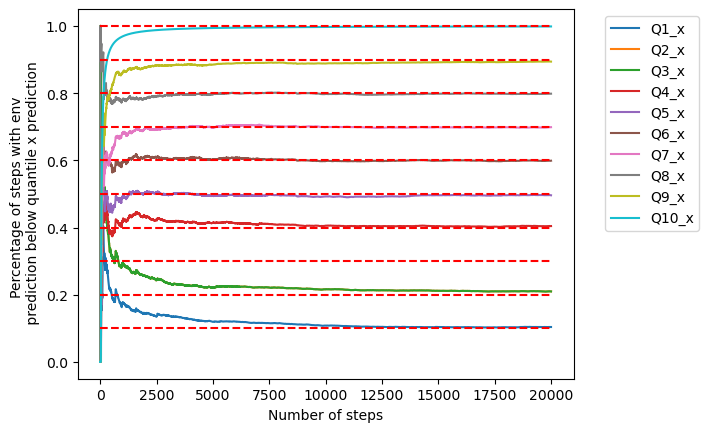

In [38]:
# x 
variable = "x"
nb_belowq1_list_x, nb_belowq2_list_x, nb_belowq3_list_x, nb_belowq4_list_x, nb_belowq5_list_x, nb_belowq6_list_x, nb_belowq7_list_x, nb_belowq8_list_x, nb_belowq9_list_x, nb_belowq10_list_x = nb_below_quantile(env_x, quantile0_x, quantile1_x, quantile2_x, quantile3_x, quantile4_x, quantile5_x, quantile6_x, quantile7_x, quantile8_x, quantile9_x, quantile10_x)
plot_nb_below_quantiles(prob, nb_belowq1_list_x, nb_belowq2_list_x, nb_belowq3_list_x, nb_belowq4_list_x, nb_belowq5_list_x, nb_belowq6_list_x, nb_belowq7_list_x, nb_belowq8_list_x, nb_belowq9_list_x, nb_belowq10_list_x, variable)



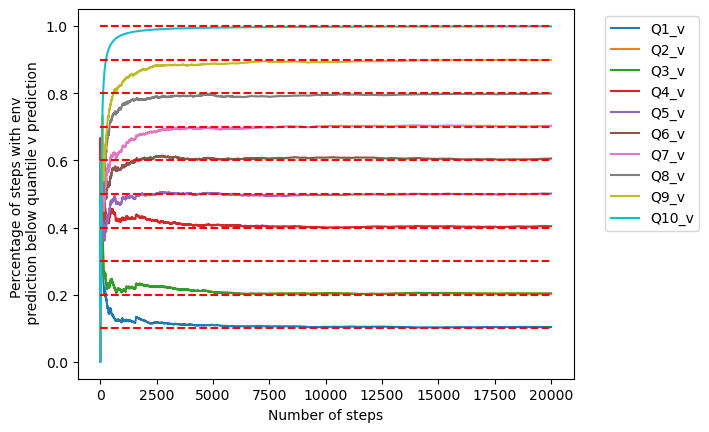

In [39]:
# v
variable = "v"
nb_belowq1_list_v, nb_belowq2_list_v, nb_belowq3_list_v, nb_belowq4_list_v, nb_belowq5_list_v, nb_belowq6_list_v, nb_belowq7_list_v, nb_belowq8_list_v, nb_belowq9_list_v, nb_belowq10_list_v = nb_below_quantile(env_v, quantile0_v, quantile1_v, quantile2_v, quantile3_v, quantile4_v, quantile5_v, quantile6_v, quantile7_v, quantile8_v, quantile9_v, quantile10_v)
plot_nb_below_quantiles(prob, nb_belowq1_list_v, nb_belowq2_list_v, nb_belowq3_list_v, nb_belowq4_list_v, nb_belowq5_list_v, nb_belowq6_list_v, nb_belowq7_list_v, nb_belowq8_list_v, nb_belowq9_list_v, nb_belowq10_list_v, variable)


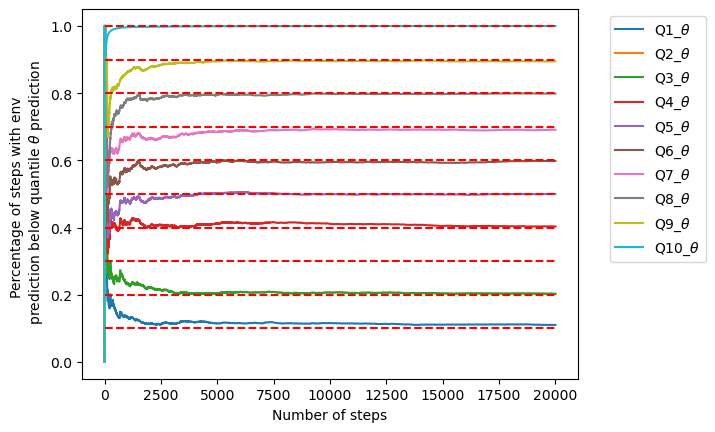

In [40]:
# theta
variable = "theta"
nb_belowq1_list_theta, nb_belowq2_list_theta, nb_belowq3_list_theta, nb_belowq4_list_theta, nb_belowq5_list_theta, nb_belowq6_list_theta, nb_belowq7_list_theta, nb_belowq8_list_theta, nb_belowq9_list_theta, nb_belowq10_list_theta = nb_below_quantile(env_theta, quantile0_theta, quantile1_theta, quantile2_theta, quantile3_theta, quantile4_theta, quantile5_theta, quantile6_theta, quantile7_theta, quantile8_theta, quantile9_theta, quantile10_theta)
plot_nb_below_quantiles(prob, nb_belowq1_list_theta, nb_belowq2_list_theta, nb_belowq3_list_theta, nb_belowq4_list_theta, nb_belowq5_list_theta, nb_belowq6_list_theta, nb_belowq7_list_theta, nb_belowq8_list_theta, nb_belowq9_list_theta, nb_belowq10_list_theta, variable)


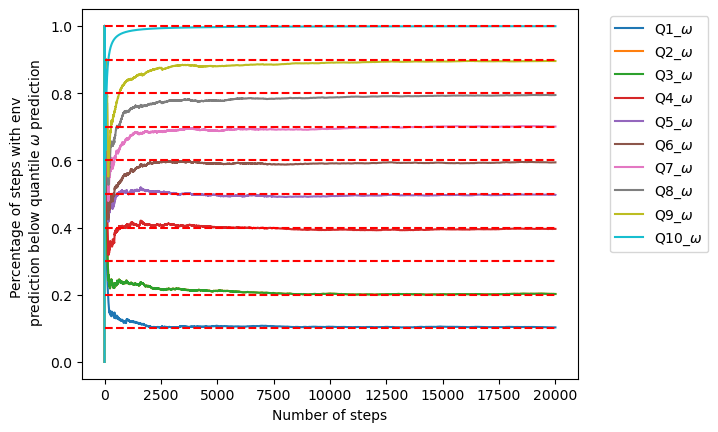

In [41]:
# omega
variable = "omega"
nb_belowq1_list_omega, nb_belowq2_list_omega, nb_belowq3_list_omega, nb_belowq4_list_omega, nb_belowq5_list_omega, nb_belowq6_list_omega, nb_belowq7_list_omega, nb_belowq8_list_omega, nb_belowq9_list_omega, nb_belowq10_list_omega = nb_below_quantile(env_omega, quantile0_omega, quantile1_omega, quantile2_omega, quantile3_omega, quantile4_omega, quantile5_omega, quantile6_omega, quantile7_omega, quantile8_omega, quantile9_omega, quantile10_omega)
plot_nb_below_quantiles(prob, nb_belowq1_list_omega, nb_belowq2_list_omega, nb_belowq3_list_omega, nb_belowq4_list_omega, nb_belowq5_list_omega, nb_belowq6_list_omega, nb_belowq7_list_omega, nb_belowq8_list_omega, nb_belowq9_list_omega, nb_belowq10_list_omega, variable)


## Pendulum 

In [42]:
prob = "Pendulum"

In [43]:
seed = 0
max_episodes = 100 # 2#0 # 300
max_episode_steps = 200 #1000
env = gym.make('Pendulum-v1').unwrapped # , render_mode='human'
# sim_env = gym.make('Pendulum-v1').unwrapped  # Additional simulation model for MPC
# sim_env.reset(seed=seed)
env.reset(seed=seed)
# np.random.seed(seed)
# random.seed(seed)

error_magnitudes_x = []
error_magnitudes_y = []
error_magnitudes_omega = []

env_x = []
env_y = []
env_omega = []
pred_x = []
pred_y = []
# pred_theta = []
pred_omega = []
# pred_x_var = []
# pred_y_var = []
# pred_z_var = []


# quantile 0 data
quantile0_x = []
quantile0_y = []
quantile0_omega = []

# quantile 1 data
quantile1_x = []
quantile1_y = []
quantile1_omega = []

# quantile 2 data
quantile2_x = []
quantile2_y = []
quantile2_omega = []

# quantile 3 data
quantile3_x = []
quantile3_y = []
quantile3_omega = []

# quantile 4 data
quantile4_x = []
quantile4_y = []
quantile4_omega = []

# quantile 5 data
quantile5_x = []
quantile5_y = []
quantile5_omega = []

# quantile 6 data
quantile6_x = []
quantile6_y = []
quantile6_omega = []

# quantile 7 data
quantile7_x = []
quantile7_y = []
quantile7_omega = []

# quantile 8 data
quantile8_x = []
quantile8_y = []
quantile8_omega = []

# quantile 9 data
quantile9_x = []
quantile9_y = []
quantile9_omega = []

# quantile 10 data
quantile10_x = []
quantile10_y = []
quantile10_omega = []

# Hyperparameters
state_dim = env.observation_space.shape[0]#-1 # Since we only care about angle and omega which are given using env.state
# action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
action_dim=1
# Define your quantiles (e.g., 0.1, 0.3, 0.7, 0.9)
# quantiles = torch.tensor([0.1, 0.3, 0.7, 0.9], dtype=torch.float32)
quantiles = torch.tensor(np.array([0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), dtype=torch.float32)

# num_quantiles = 4  # Example with 4 quantiles
num_quantiles = len(quantiles)

# Initialize the Next-State Prediction Network
model = NextStateQuantileNetwork(state_dim, action_dim, num_quantiles)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Experience replay buffer
replay_buffer = []

batch_size = 32

usingEnv = True
# usingEnv = False

# Run the simulation
# rewards = start()

num_test_steps = 20000

state, _ = env.reset(seed=seed)
episode_reward = 0
# episode_reard_list = []
actions_list = []
# state = env.state.copy()

states_low = torch.tensor([-1, -1, -8])
states_high = torch.tensor([1, 1, 8])

actions_taken = np.zeros(num_test_steps)
env.action_space.seed(seed)

discrete = False

for step in range(num_test_steps):
    action = env.action_space.sample()
    actions_taken[step] = action
    
    # Apply the first action from the optimized sequence
    next_state, reward, done, truncated, info = env.step(action)
    episode_reward += reward
    # next_state = env.state.copy()
    # print("state ", state, "next_state ", next_state, "\n")
    # print("states[0] ", state[0], "states[1] ", state[1], "\n")
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        # print("test_next_state ", test_next_state, "\n")
        
        if discrete:
            test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        else:
            test_action = torch.tensor(action, dtype=torch.float32)#.unsqueeze(1)
        # test_action = torch.tensor(action, dtype=torch.float32)#.unsqueeze(1)  # Example action
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        test_state = torch.clip(test_state, states_low, states_high)
        # Predict next state quantiles
        predicted_quantiles = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_x = np.append(pred_x, mid_quantile[0][0])
        pred_y = np.append(pred_y, mid_quantile[0][1])
        pred_omega = np.append(pred_omega, mid_quantile[0][2])
        
        ########################
        
        # Quantile 0 data
        quantile0_x = np.append(quantile0_x, predicted_quantiles[0][0][0].item())
        quantile0_y = np.append(quantile0_y, predicted_quantiles[0][0][1].item())
        quantile0_omega = np.append(quantile0_omega, predicted_quantiles[0][0][2].item())
        
        # Quantile 1 data
        quantile1_x = np.append(quantile1_x, predicted_quantiles[0][1][0].item())
        quantile1_y = np.append(quantile1_y, predicted_quantiles[0][1][1].item())
        quantile1_omega = np.append(quantile1_omega, predicted_quantiles[0][1][2].item())
        
        # Quantile 2 data
        quantile2_x = np.append(quantile2_x, predicted_quantiles[0][2][0].item())
        quantile2_y = np.append(quantile2_y, predicted_quantiles[0][2][1].item())
        quantile2_omega = np.append(quantile2_omega, predicted_quantiles[0][2][2].item())
        
        # Quantile 3 data
        quantile3_x = np.append(quantile3_x, predicted_quantiles[0][3][0].item())
        quantile3_y = np.append(quantile3_y, predicted_quantiles[0][3][1].item())
        quantile3_omega = np.append(quantile3_omega, predicted_quantiles[0][3][2].item())
        
        # Quantile 4 data
        quantile4_x = np.append(quantile4_x, predicted_quantiles[0][4][0].item())
        quantile4_y = np.append(quantile4_y, predicted_quantiles[0][4][1].item())
        quantile4_omega = np.append(quantile4_omega, predicted_quantiles[0][4][2].item())
        
        # Quantile 5 data
        quantile5_x = np.append(quantile5_x, predicted_quantiles[0][5][0].item())
        quantile5_y = np.append(quantile5_y, predicted_quantiles[0][5][1].item())
        quantile5_omega = np.append(quantile5_omega, predicted_quantiles[0][5][2].item())
        
        # Quantile 6 data
        quantile6_x = np.append(quantile0_x, predicted_quantiles[0][6][0].item())
        quantile6_y = np.append(quantile0_y, predicted_quantiles[0][6][1].item())
        quantile6_omega = np.append(quantile0_omega, predicted_quantiles[0][6][2].item())
        
        # Quantile 7 data
        quantile7_x = np.append(quantile7_x, predicted_quantiles[0][7][0].item())
        quantile7_y = np.append(quantile7_y, predicted_quantiles[0][7][1].item())
        quantile7_omega = np.append(quantile7_omega, predicted_quantiles[0][7][2].item())
        
        # Quantile 8 data
        quantile8_x = np.append(quantile8_x, predicted_quantiles[0][8][0].item())
        quantile8_y = np.append(quantile8_y, predicted_quantiles[0][8][1].item())
        quantile8_omega = np.append(quantile8_omega, predicted_quantiles[0][8][2].item())
        
        # Quantile 9 data
        quantile9_x = np.append(quantile9_x, predicted_quantiles[0][9][0].item())
        quantile9_y = np.append(quantile9_y, predicted_quantiles[0][9][1].item())
        quantile9_omega = np.append(quantile9_omega, predicted_quantiles[0][9][2].item())

        # Quantile 10 data
        quantile10_x = np.append(quantile10_x, predicted_quantiles[0][10][0].item())
        quantile10_y = np.append(quantile10_y, predicted_quantiles[0][10][1].item())
        quantile10_omega = np.append(quantile10_omega, predicted_quantiles[0][10][2].item())
        
        deltax = test_next_state[0] - mid_quantile[0][0]
        deltay = test_next_state[1] - mid_quantile[0][1]
        deltaomega = test_next_state[2] - mid_quantile[0][2]

        # delta = env_test_state - mean_next_state.flatten()#.detach().numpy()
        # print("delta ", delta, "\n") # 6
        # print("delta_x ", deltax, "\n") # 7
        # error_magnitude = np.linalg.norm(delta)
        # error_magnitudes.append(error_magnitude)
        error_magnitudes_x.append(np.abs(deltax)) # .detach().numpy()
        error_magnitudes_y.append(np.abs(deltay)) # .detach().numpy()
        error_magnitudes_omega.append(np.abs(deltaomega)) # .detach().numpy()
        # env_next_states.append(env_test_state)
        env_x.append(test_next_state[0])
        env_y.append(test_next_state[1])
        env_omega.append(test_next_state[2])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    # print("state ", state, "\n")
    replay_buffer.append((state, action, reward, next_state, done))
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # print("batch states ", states, "\n")
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        states = torch.clip(states, states_low, states_high)
        
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # Compute Quantile Huber Loss
        loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # if step > 198:
    #     print("done ", done, "\n")
    #     print("terminated ", terminated, "\n")
    
    state = next_state

    # Terminate if done
    if done or truncated: # Done does nothing here
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        actions_list = []
        state = env.state.copy()



C:\Users\nicle\AppData\Local\Temp\ipykernel_2104\1796248878.py:126: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actions_taken[step] = action


Plots for the pendulum env

In [44]:
# import matplotlib.pyplot as plt
# # # Plot the rewards
# # plt.figure(1)
# # # plt.legend()
# # # plt.grid()
# # plt.plot(episode_reward_list)
# # plt.xlabel('Nb of episodes')
# # plt.ylabel('episode reward')
# # # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')

# plt.figure(2)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_theta)
# plt.ylabel('error_magnitudes_theta')
# plt.yscale('log')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')

# plt.figure(3)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_omega)
# plt.ylabel('error_magnitudes_omega')
# plt.yscale('log')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')


# plt.figure(4)
# plt.xlabel('Nb of steps')
# plt.ylabel('theta comparison between env and QRNN')
# plt.plot(env_theta, label='env_next_states')
# plt.plot(pred_theta, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_1std, pred_theta + pred_theta_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_2std, pred_theta + pred_theta_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(5)
# plt.xlabel('Nb of steps')
# plt.ylabel('omega comparison between env and QRNN')
# plt.plot(env_omega, label='env_next_states')
# plt.plot(pred_omega, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_1std, pred_omega + pred_omega_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_2std, pred_omega + pred_omega_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()




Graph of number of values below the different quantiles


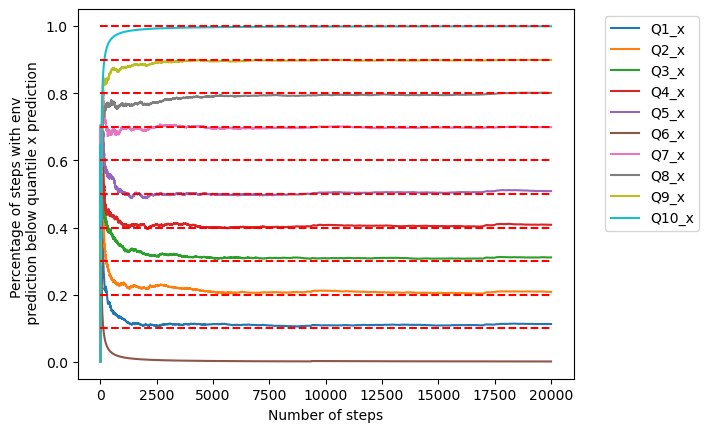

In [45]:
# x
variable = "x"
nb_belowq1_list_x, nb_belowq2_list_x, nb_belowq3_list_x, nb_belowq4_list_x, nb_belowq5_list_x, nb_belowq6_list_x, nb_belowq7_list_x, nb_belowq8_list_x, nb_belowq9_list_x, nb_belowq10_list_x = nb_below_quantile(env_x, quantile0_x, quantile1_x, quantile2_x, quantile3_x, quantile4_x, quantile5_x, quantile6_x, quantile7_x, quantile8_x, quantile9_x, quantile10_x)
plot_nb_below_quantiles(prob, nb_belowq1_list_x, nb_belowq2_list_x, nb_belowq3_list_x, nb_belowq4_list_x, nb_belowq5_list_x, nb_belowq6_list_x, nb_belowq7_list_x, nb_belowq8_list_x, nb_belowq9_list_x, nb_belowq10_list_x, variable)


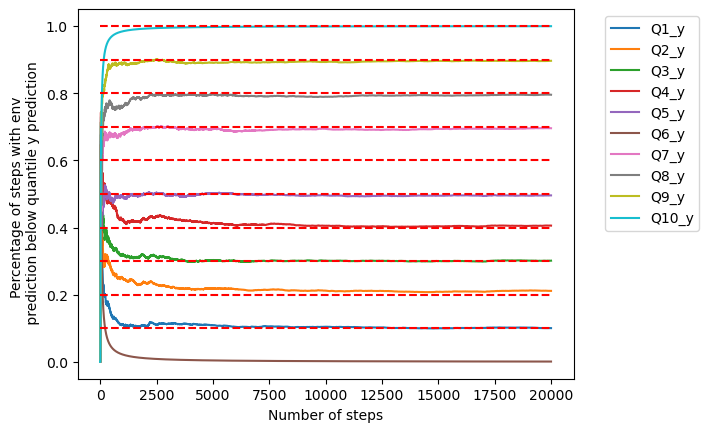

In [46]:
# y
variable = "y"
nb_belowq1_list_y, nb_belowq2_list_y, nb_belowq3_list_y, nb_belowq4_list_y, nb_belowq5_list_y, nb_belowq6_list_y, nb_belowq7_list_y, nb_belowq8_list_y, nb_belowq9_list_y, nb_belowq10_list_y = nb_below_quantile(env_y, quantile0_y, quantile1_y, quantile2_y, quantile3_y, quantile4_y, quantile5_y, quantile6_y, quantile7_y, quantile8_y, quantile9_y, quantile10_y)
plot_nb_below_quantiles(prob, nb_belowq1_list_y, nb_belowq2_list_y, nb_belowq3_list_y, nb_belowq4_list_y, nb_belowq5_list_y, nb_belowq6_list_y, nb_belowq7_list_y, nb_belowq8_list_y, nb_belowq9_list_y, nb_belowq10_list_y, variable)


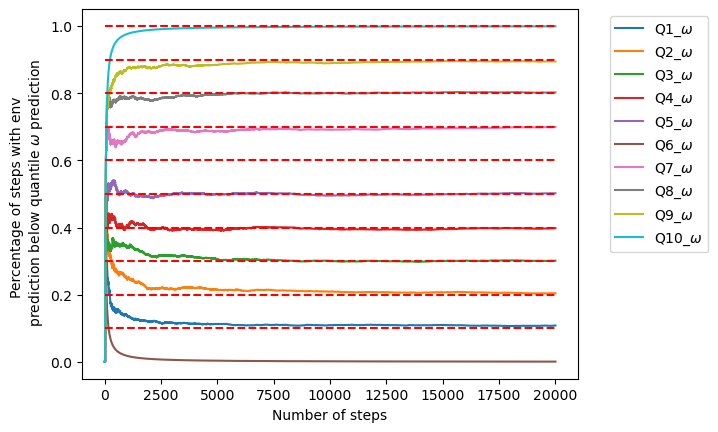

In [47]:
# omega
variable = "omega"
nb_belowq1_list_omega, nb_belowq2_list_omega, nb_belowq3_list_omega, nb_belowq4_list_omega, nb_belowq5_list_omega, nb_belowq6_list_omega, nb_belowq7_list_omega, nb_belowq8_list_omega, nb_belowq9_list_omega, nb_belowq10_list_omega = nb_below_quantile(env_omega, quantile0_omega, quantile1_omega, quantile2_omega, quantile3_omega, quantile4_omega, quantile5_omega, quantile6_omega, quantile7_omega, quantile8_omega, quantile9_omega, quantile10_omega)
plot_nb_below_quantiles(prob, nb_belowq1_list_omega, nb_belowq2_list_omega, nb_belowq3_list_omega, nb_belowq4_list_omega, nb_belowq5_list_omega, nb_belowq6_list_omega, nb_belowq7_list_omega, nb_belowq8_list_omega, nb_belowq9_list_omega, nb_belowq10_list_omega, variable)


## Mountain car

In [48]:
prob = "MountainCar"

Trying different PF and pre-trained using rnd actions QRNN - Feb 4


- PF + Run 

In [49]:
seed = 0
env = gym.make('MountainCarContinuous-v0').unwrapped # , render_mode='human'
# sim_env = gym.make('MountainCarContinuous-v0').unwrapped  # Additional simulation model for MPC
# sim_env.reset(seed=seed)
env.reset(seed=seed)
# np.random.seed(seed)
# random.seed(seed)

error_magnitudes_x = []
error_magnitudes_v = []

env_x = []
env_v = []
pred_x = []
pred_v = []

# quantile 0 data
quantile0_x = []
quantile0_v = []

# quantile 1 data
quantile1_x = []
quantile1_v = []

# quantile 2 data
quantile2_x = []
quantile2_v = []

# quantile 3 data
quantile3_x = []
quantile3_v = []

# quantile 4 data
quantile4_x = []
quantile4_v = []

# quantile 5 data
quantile5_x = []
quantile5_v = []

# quantile 6 data
quantile6_x = []
quantile6_v = []

# quantile 7 data
quantile7_x = []
quantile7_v = []

# quantile 8 data
quantile8_x = []
quantile8_v = []

# quantile 9 data
quantile9_x = []
quantile9_v = []

# quantile 10 data
quantile10_x = []
quantile10_v = []

# Hyperparameters
state_dim = env.observation_space.shape[0] #-1 # Since we only care about angle and omega which are given using env.state
# action_dim = env.action_space.shape[0]  # For Pendulum, it's continuous
action_dim=1
# Define your quantiles (e.g., 0.1, 0.3, 0.7, 0.9)
# quantiles = torch.tensor([0.1, 0.3, 0.7, 0.9], dtype=torch.float32)
quantiles = torch.tensor(np.array([0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), dtype=torch.float32)

# num_quantiles = 4  # Example with 4 quantiles
num_quantiles = len(quantiles)

# Initialize the Next-State Prediction Network
model = NextStateQuantileNetwork(state_dim, action_dim, num_quantiles)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Experience replay buffer
replay_buffer = []

batch_size = 32

# usingEnv = True
usingEnv = False

# Run the simulation
# rewards = start()

num_test_steps = 20000

state, _ = env.reset(seed=seed)
done = False
truncated = False
episode_reward = 0
actions_list = []

discrete = False
states_low = torch.tensor([-1.2, -0.07])
states_high = torch.tensor([0.6, 0.07])
actions_taken = np.zeros(num_test_steps)
env.action_space.seed(seed)


for step in range(num_test_steps):
    action = env.action_space.sample()
    actions_taken[step] = action

    # Apply the first action from the optimized sequence
    next_state, reward, done, terminated, info = env.step(action)
    episode_reward += reward
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        # print("test_next_state ", test_next_state, "\n")
        
        if discrete:
            test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        else:
            test_action = torch.tensor(action, dtype=torch.float32)#.unsqueeze(1)
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        test_state = torch.clip(test_state, states_low, states_high)

        # Predict next state quantiles
        predicted_quantiles = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_x = np.append(pred_x, mid_quantile[0][0])
        pred_v = np.append(pred_v, mid_quantile[0][1])
        
        
        ########################
        
        # Quantile 0 data
        quantile0_x = np.append(quantile0_x, predicted_quantiles[0][0][0].item())
        quantile0_v = np.append(quantile0_v, predicted_quantiles[0][0][1].item())
        
        # Quantile 1 data
        quantile1_x = np.append(quantile1_x, predicted_quantiles[0][1][0].item())
        quantile1_v = np.append(quantile1_v, predicted_quantiles[0][1][1].item())
        
        # Quantile 2 data
        quantile2_x = np.append(quantile2_x, predicted_quantiles[0][2][0].item())
        quantile2_v = np.append(quantile2_v, predicted_quantiles[0][2][1].item())
        
        # Quantile 3 data
        quantile3_x = np.append(quantile3_x, predicted_quantiles[0][3][0].item())
        quantile3_v = np.append(quantile3_v, predicted_quantiles[0][3][1].item())
        
        # Quantile 4 data
        quantile4_x = np.append(quantile4_x, predicted_quantiles[0][4][0].item())
        quantile4_v = np.append(quantile4_v, predicted_quantiles[0][4][1].item())
        
        # Quantile 5 data
        quantile5_x = np.append(quantile5_x, predicted_quantiles[0][5][0].item())
        quantile5_v = np.append(quantile5_v, predicted_quantiles[0][5][1].item())
        
        # Quantile 6 data
        quantile6_x = np.append(quantile6_x, predicted_quantiles[0][6][0].item())
        quantile6_v = np.append(quantile6_v, predicted_quantiles[0][6][1].item())
        
        # Quantile 7 data
        quantile7_x = np.append(quantile7_x, predicted_quantiles[0][7][0].item())
        quantile7_v = np.append(quantile7_v, predicted_quantiles[0][7][1].item())
        
        # Quantile 8 data
        quantile8_x = np.append(quantile8_x, predicted_quantiles[0][8][0].item())
        quantile8_v = np.append(quantile8_v, predicted_quantiles[0][8][1].item())
        
        # Quantile 9 data
        quantile9_x = np.append(quantile9_x, predicted_quantiles[0][9][0].item())
        quantile9_v = np.append(quantile9_v, predicted_quantiles[0][9][1].item())

        # Quantile 10 data
        quantile10_x = np.append(quantile10_x, predicted_quantiles[0][10][0].item())
        quantile10_v = np.append(quantile10_v, predicted_quantiles[0][10][1].item())
    
        
        deltax = test_next_state[0] - mid_quantile[0][0]
        deltav = test_next_state[1] - mid_quantile[0][1]

        # delta = env_test_state - mean_next_state.flatten()#.detach().numpy()
        # print("delta ", delta, "\n") # 6
        # print("delta_x ", deltax, "\n") # 7
        # error_magnitude = np.linalg.norm(delta)
        # error_magnitudes.append(error_magnitude)
        error_magnitudes_x.append(np.abs(deltax)) # .detach().numpy()
        error_magnitudes_v.append(np.abs(deltav)) # .detach().numpy()
        # env_next_states.append(env_test_state)
        env_x.append(test_next_state[0])
        env_v.append(test_next_state[1])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    replay_buffer.append((state, action, reward, next_state, done))
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        states = torch.clip(states, states_low, states_high)
        
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # Compute Quantile Huber Loss
        loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)

        
        # Compute Quantile Huber Loss
        loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    state = next_state

    # Terminate if done
    if done or terminated: # Done does nothing here
        state, _ = env.reset(seed=seed)
        done = False
        truncated = False
    


C:\Users\nicle\AppData\Local\Temp\ipykernel_2104\2531860254.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actions_taken[step] = action


Plots for continuous MC env

In [50]:
# import matplotlib.pyplot as plt
# # # Plot the rewards
# # plt.figure(1)
# # # plt.legend()
# # # plt.grid()
# # plt.plot(episode_reward_list)
# # plt.xlabel('Nb of episodes')
# # plt.ylabel('episode reward')
# # # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')

# plt.figure(2)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_x)
# plt.ylabel('error_magnitudes_x')
# plt.yscale('log')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')

# plt.figure(3)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_v)
# plt.ylabel('error_magnitudes_v')
# plt.yscale('log')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')


# plt.figure(4)
# plt.xlabel('Nb of steps')
# plt.ylabel('x comparison between env and QRNN')
# plt.plot(env_x, label='env_next_states')
# plt.plot(pred_x, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_1std, pred_theta + pred_theta_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_theta)), pred_theta - pred_theta_bottom_2std, pred_theta + pred_theta_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(5)
# plt.xlabel('Nb of steps')
# plt.ylabel('v comparison between env and QRNN')
# plt.plot(env_v, label='env_next_states')
# plt.plot(pred_v, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_1std, pred_omega + pred_omega_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_omega)), pred_omega - pred_omega_bottom_2std, pred_omega + pred_omega_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()




Graph of number of values below the different quantiles


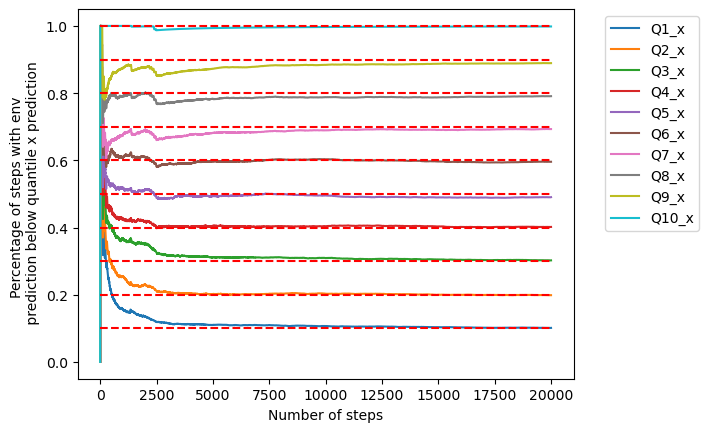

In [51]:
# x 
variable = "x"
nb_belowq1_list_x, nb_belowq2_list_x, nb_belowq3_list_x, nb_belowq4_list_x, nb_belowq5_list_x, nb_belowq6_list_x, nb_belowq7_list_x, nb_belowq8_list_x, nb_belowq9_list_x, nb_belowq10_list_x = nb_below_quantile(env_x, quantile0_x, quantile1_x, quantile2_x, quantile3_x, quantile4_x, quantile5_x, quantile6_x, quantile7_x, quantile8_x, quantile9_x, quantile10_x)
plot_nb_below_quantiles(prob, nb_belowq1_list_x, nb_belowq2_list_x, nb_belowq3_list_x, nb_belowq4_list_x, nb_belowq5_list_x, nb_belowq6_list_x, nb_belowq7_list_x, nb_belowq8_list_x, nb_belowq9_list_x, nb_belowq10_list_x, variable)



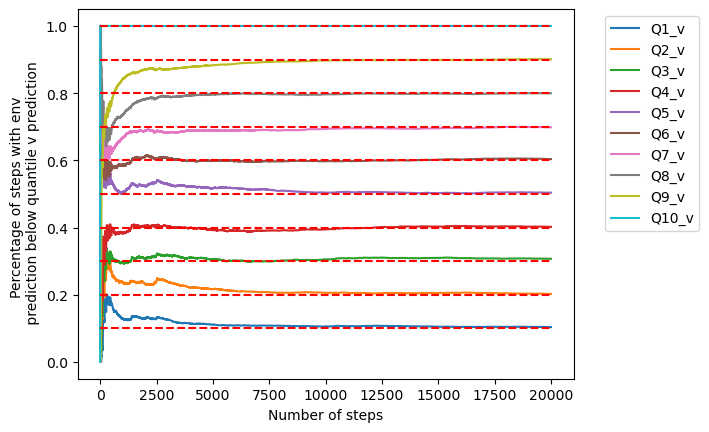

In [52]:
# v
variable = "v"
nb_belowq1_list_v, nb_belowq2_list_v, nb_belowq3_list_v, nb_belowq4_list_v, nb_belowq5_list_v, nb_belowq6_list_v, nb_belowq7_list_v, nb_belowq8_list_v, nb_belowq9_list_v, nb_belowq10_list_v = nb_below_quantile(env_v, quantile0_v, quantile1_v, quantile2_v, quantile3_v, quantile4_v, quantile5_v, quantile6_v, quantile7_v, quantile8_v, quantile9_v, quantile10_v)
plot_nb_below_quantiles(prob, nb_belowq1_list_v, nb_belowq2_list_v, nb_belowq3_list_v, nb_belowq4_list_v, nb_belowq5_list_v, nb_belowq6_list_v, nb_belowq7_list_v, nb_belowq8_list_v, nb_belowq9_list_v, nb_belowq10_list_v, variable)


## Panda Dense reward Reach (3D)

In [53]:
prob = "PandaReach"

### Using states and velocities of env as input and output of QRNN

In [54]:
import panda_gym
seed = 0
env = gym.make('PandaReachDense-v3').unwrapped # , render_mode='human'
# sim_env = gym.make('PandaReachDense-v3').unwrapped  # Additional simulation model for MPC
# sim_env.reset(seed=seed)
env.reset(seed=seed)
# np.random.seed(seed)
# random.seed(seed)

error_magnitudes_x = []
error_magnitudes_y = []
error_magnitudes_z = []
error_magnitudes_vx = []
error_magnitudes_vy = []
error_magnitudes_vz = []

env_x = []
env_y = []
env_z = []
env_vx = []
env_vy = []
env_vz = []

pred_x = []
pred_y = []
pred_z = []
pred_vx = []
pred_vy = []
pred_vz = []

# quantile 0 data
quantile0_x = []
quantile0_y = []
quantile0_z = []
quantile0_vx = []
quantile0_vy = []
quantile0_vz = []

# quantile 1 data
quantile1_x = []
quantile1_y = []
quantile1_z = []
quantile1_vx = []
quantile1_vy = []
quantile1_vz = []

# quantile 2 data
quantile2_x = []
quantile2_y = []
quantile2_z = []
quantile2_vx = []
quantile2_vy = []
quantile2_vz = []

# quantile 3 data
quantile3_x = []
quantile3_y = []
quantile3_z = []
quantile3_vx = []
quantile3_vy = []
quantile3_vz = []

# quantile 4 data
quantile4_x = []
quantile4_y = []
quantile4_z = []
quantile4_vx = []
quantile4_vy = []
quantile4_vz = []

# quantile 5 data
quantile5_x = []
quantile5_y = []
quantile5_z = []
quantile5_vx = []
quantile5_vy = []
quantile5_vz = []

# quantile 6 data
quantile6_x = []
quantile6_y = []
quantile6_z = []
quantile6_vx = []
quantile6_vy = []
quantile6_vz = []

# quantile 7 data
quantile7_x = []
quantile7_y = []
quantile7_z = []
quantile7_vx = []
quantile7_vy = []
quantile7_vz = []

# quantile 8 data
quantile8_x = []
quantile8_y = []
quantile8_z = []
quantile8_vx = []
quantile8_vy = []
quantile8_vz = []

# quantile 9 data
quantile9_x = []
quantile9_y = []
quantile9_z = []
quantile9_vx = []
quantile9_vy = []
quantile9_vz = []

# quantile 10 data
quantile10_x = []
quantile10_y = []
quantile10_z = []
quantile10_vx = []
quantile10_vy = []
quantile10_vz = []


actions_low = env.action_space.low#[:3]
actions_high = env.action_space.high#[:3]
states_low = env.observation_space['observation'].low#[:3]
states_high = env.observation_space['observation'].high#[:3]
state_dim = len(states_low)
action_dim = len(actions_low)
states_low = torch.tensor([-10, -10, -10, -10, -10, -10])
states_high = torch.tensor([10, 10, 10, 10, 10, 10])

# Hyperparameters
# state_dim = len(states_low)
# action_dim = len(actions_low)
# Define your quantiles (e.g., 0.1, 0.3, 0.7, 0.9)
# quantiles = torch.tensor([0.1, 0.3, 0.7, 0.9], dtype=torch.float32)
quantiles = torch.tensor(np.array([0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), dtype=torch.float32)

# num_quantiles = 4  # Example with 4 quantiles
num_quantiles = len(quantiles)

# Initialize the Next-State Prediction Network
model = NextStateQuantileNetwork(state_dim, action_dim, num_quantiles)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Experience replay buffer
replay_buffer = []

batch_size = 32

num_test_steps = 20000
state, _ = env.reset(seed=seed)
episode_reward = 0
actions_list = []
done = False
truncated = False

goal_state = state['desired_goal'] # 3 components
state = state['observation']#[:3] # 6 components

discrete = False
actions_taken = np.zeros((num_test_steps, action_dim))
env.action_space.seed(seed)

for step in range(num_test_steps):
    action = env.action_space.sample()
    actions_taken[step] = action
    
    next_state, reward, done, truncated, info = env.step(action)
    episode_reward += reward
    next_state = next_state['observation']#[:3] # env.state
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        # print("test_next_state ", test_next_state, "\n")
        
        if discrete:
            test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        else:
            test_action = torch.tensor(action, dtype=torch.float32)#.unsqueeze(1)
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        test_state = torch.clip(test_state, states_low, states_high)

        # Predict next state quantiles
        predicted_quantiles = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_x = np.append(pred_x, mid_quantile[0][0])
        pred_y = np.append(pred_y, mid_quantile[0][1])
        pred_z = np.append(pred_z, mid_quantile[0][2])
        pred_vx = np.append(pred_vx, mid_quantile[0][3])
        pred_vy = np.append(pred_vy, mid_quantile[0][4])
        pred_vz = np.append(pred_vz, mid_quantile[0][5])
        
        # Quantile 0 data
        quantile0_x = np.append(quantile0_x, predicted_quantiles[0][0][0].item())
        quantile0_y = np.append(quantile0_y, predicted_quantiles[0][0][1].item())
        quantile0_z = np.append(quantile0_z, predicted_quantiles[0][0][2].item())
        quantile0_vx = np.append(quantile0_vx, predicted_quantiles[0][0][3].item())
        quantile0_vy = np.append(quantile0_vy, predicted_quantiles[0][0][4].item())
        quantile0_vz = np.append(quantile0_vz, predicted_quantiles[0][0][5].item())
        
        # Quantile 1 data
        quantile1_x = np.append(quantile1_x, predicted_quantiles[0][1][0].item())
        quantile1_y = np.append(quantile1_y, predicted_quantiles[0][1][1].item())
        quantile1_z = np.append(quantile1_z, predicted_quantiles[0][1][2].item())
        quantile1_vx = np.append(quantile1_vx, predicted_quantiles[0][1][3].item())
        quantile1_vy = np.append(quantile1_vy, predicted_quantiles[0][1][4].item())
        quantile1_vz = np.append(quantile1_vz, predicted_quantiles[0][1][5].item())
        
        # Quantile 2 data
        quantile2_x = np.append(quantile2_x, predicted_quantiles[0][2][0].item())
        quantile2_y = np.append(quantile2_y, predicted_quantiles[0][2][1].item())
        quantile2_z = np.append(quantile2_z, predicted_quantiles[0][2][2].item())
        quantile2_vx = np.append(quantile2_vx, predicted_quantiles[0][2][3].item())
        quantile2_vy = np.append(quantile2_vy, predicted_quantiles[0][2][4].item())
        quantile2_vz = np.append(quantile2_vz, predicted_quantiles[0][2][5].item())
        
        # Quantile 3 data
        quantile3_x = np.append(quantile3_x, predicted_quantiles[0][3][0].item())
        quantile3_y = np.append(quantile3_y, predicted_quantiles[0][3][1].item())
        quantile3_z = np.append(quantile3_z, predicted_quantiles[0][3][2].item())
        quantile3_vx = np.append(quantile3_vx, predicted_quantiles[0][3][3].item())
        quantile3_vy = np.append(quantile3_vy, predicted_quantiles[0][3][4].item())
        quantile3_vz = np.append(quantile3_vz, predicted_quantiles[0][3][5].item())
        
        # Quantile 4 data
        quantile4_x = np.append(quantile4_x, predicted_quantiles[0][4][0].item())
        quantile4_y = np.append(quantile4_y, predicted_quantiles[0][4][1].item())
        quantile4_z = np.append(quantile4_z, predicted_quantiles[0][4][2].item())
        quantile4_vx = np.append(quantile4_vx, predicted_quantiles[0][4][3].item())
        quantile4_vy = np.append(quantile4_vy, predicted_quantiles[0][4][4].item())
        quantile4_vz = np.append(quantile4_vz, predicted_quantiles[0][4][5].item())
        
        # Quantile 5 data
        quantile5_x = np.append(quantile5_x, predicted_quantiles[0][5][0].item())
        quantile5_y = np.append(quantile5_y, predicted_quantiles[0][5][1].item())
        quantile5_z = np.append(quantile5_z, predicted_quantiles[0][5][2].item())
        quantile5_vx = np.append(quantile5_vx, predicted_quantiles[0][5][3].item())
        quantile5_vy = np.append(quantile5_vy, predicted_quantiles[0][5][4].item())
        quantile5_vz = np.append(quantile5_vz, predicted_quantiles[0][5][5].item())
        
        # Quantile 6 data
        quantile6_x = np.append(quantile6_x, predicted_quantiles[0][6][0].item())
        quantile6_y = np.append(quantile6_y, predicted_quantiles[0][6][1].item())
        quantile6_z = np.append(quantile6_z, predicted_quantiles[0][6][2].item())
        quantile6_vx = np.append(quantile6_vx, predicted_quantiles[0][6][3].item())
        quantile6_vy = np.append(quantile6_vy, predicted_quantiles[0][6][4].item())
        quantile6_vz = np.append(quantile6_vz, predicted_quantiles[0][6][5].item())
        
        # Quantile 7 data
        quantile7_x = np.append(quantile7_x, predicted_quantiles[0][7][0].item())
        quantile7_y = np.append(quantile7_y, predicted_quantiles[0][7][1].item())
        quantile7_z = np.append(quantile7_z, predicted_quantiles[0][7][2].item())
        quantile7_vx = np.append(quantile7_vx, predicted_quantiles[0][7][3].item())
        quantile7_vy = np.append(quantile7_vy, predicted_quantiles[0][7][4].item())
        quantile7_vz = np.append(quantile7_vz, predicted_quantiles[0][7][5].item())
        
        # Quantile 8 data
        quantile8_x = np.append(quantile8_x, predicted_quantiles[0][8][0].item())
        quantile8_y = np.append(quantile8_y, predicted_quantiles[0][8][1].item())
        quantile8_z = np.append(quantile8_z, predicted_quantiles[0][8][2].item())
        quantile8_vx = np.append(quantile8_vx, predicted_quantiles[0][8][3].item())
        quantile8_vy = np.append(quantile8_vy, predicted_quantiles[0][8][4].item())
        quantile8_vz = np.append(quantile8_vz, predicted_quantiles[0][8][5].item())
        
        # Quantile 9 data
        quantile9_x = np.append(quantile9_x, predicted_quantiles[0][9][0].item())
        quantile9_y = np.append(quantile9_y, predicted_quantiles[0][9][1].item())
        quantile9_z = np.append(quantile9_z, predicted_quantiles[0][9][2].item())
        quantile9_vx = np.append(quantile9_vx, predicted_quantiles[0][9][3].item())
        quantile9_vy = np.append(quantile9_vy, predicted_quantiles[0][9][4].item())
        quantile9_vz = np.append(quantile9_vz, predicted_quantiles[0][9][5].item())
        
        # Quantile 10 data
        quantile10_x = np.append(quantile10_x, predicted_quantiles[0][10][0].item())
        quantile10_y = np.append(quantile10_y, predicted_quantiles[0][10][1].item())
        quantile10_z = np.append(quantile10_z, predicted_quantiles[0][10][2].item())
        quantile10_vx = np.append(quantile10_vx, predicted_quantiles[0][10][3].item())
        quantile10_vy = np.append(quantile10_vy, predicted_quantiles[0][10][4].item())
        quantile10_vz = np.append(quantile10_vz, predicted_quantiles[0][10][5].item())
        
    
        
        deltax = test_next_state[0] - mid_quantile[0][0]
        deltay = test_next_state[1] - mid_quantile[0][1]
        deltaz = test_next_state[2] - mid_quantile[0][2]
        # delta = env_test_state - mean_next_state.flatten()#.detach().numpy()
        # print("delta ", delta, "\n") # 6
        # print("delta_x ", deltax, "\n") # 7
        # error_magnitude = np.linalg.norm(delta)
        # error_magnitudes.append(error_magnitude)
        error_magnitudes_x.append(np.abs(deltax)) # .detach().numpy()
        error_magnitudes_y.append(np.abs(deltay)) # .detach().numpy()
        error_magnitudes_z.append(np.abs(deltaz)) # .detach().numpy()
        # env_next_states.append(env_test_state)
        env_x.append(test_next_state[0])
        env_y.append(test_next_state[1])
        env_z.append(test_next_state[2])
        
        
        deltavx = test_next_state[3] - mid_quantile[0][3]
        deltavy = test_next_state[4] - mid_quantile[0][4]
        deltavz = test_next_state[5] - mid_quantile[0][5]
        # delta = env_test_state - mean_next_state.flatten()#.detach().numpy()
        # print("delta ", delta, "\n") # 6
        # print("delta_x ", deltax, "\n") # 7
        # error_magnitude = np.linalg.norm(delta)
        # error_magnitudes.append(error_magnitude)
        error_magnitudes_vx.append(np.abs(deltavx)) # .detach().numpy()
        error_magnitudes_vy.append(np.abs(deltavy)) # .detach().numpy()
        error_magnitudes_vz.append(np.abs(deltavz)) # .detach().numpy()
        # env_next_states.append(env_test_state)
        env_vx.append(test_next_state[3])
        env_vy.append(test_next_state[4])
        env_vz.append(test_next_state[5])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    replay_buffer.append((state, action, reward, next_state, done))
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        states = torch.clip(states, states_low, states_high)
        
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # Compute Quantile Huber Loss
        loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)
        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    state = next_state

    if done or truncated:
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        actions_list = []
        done = False
        truncated = False
        
        goal_state = state['desired_goal'] # 3 components
        state = state['observation']#[:3] # 6 components



Graphs

In [55]:
# %matplotlib inline

# import matplotlib.pyplot as plt
# # Plot the rewards
# plt.figure(1)
# # plt.legend()
# # plt.grid()
# plt.plot(episode_reward_list)
# plt.xlabel('Nb of episodes')
# plt.ylabel('episode reward')
# # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')
# plt.yscale('log')

# plt.figure(2)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_x)
# plt.ylabel('error_magnitudes_x')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
# plt.yscale('log')

# plt.figure(3)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_y)
# plt.ylabel('error_magnitudes_y')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(4)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_z)
# plt.ylabel('error_magnitudes_z')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(5)
# plt.xlabel('Nb of steps')
# plt.ylabel('x comparison between env and QRNN')
# plt.plot(env_x, label='env_next_states')
# plt.plot(pred_x, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# # plt.yscale('log')
# plt.legend()

# plt.figure(6)
# plt.xlabel('Nb of steps')
# plt.ylabel('y comparison between env and QRNN')
# plt.plot(env_y, label='env_next_states')
# plt.plot(pred_y, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# # plt.yscale('log')
# plt.legend()

# plt.figure(7)
# plt.xlabel('Nb of steps')
# plt.ylabel('z comparison between env and QRNN')
# plt.plot(env_z, label='env_next_states')
# plt.plot(pred_z, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_z)), pred_z - pred_z_bottom_1std, pred_z + pred_z_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_z)), pred_z - pred_z_bottom_2std, pred_z + pred_z_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# # plt.yscale('log')
# plt.legend()

# plt.figure(8)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_vx)
# plt.ylabel('error_magnitudes_vx')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
# plt.yscale('log')

# plt.figure(9)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_vy)
# plt.ylabel('error_magnitudes_vy')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(10)
# plt.xlabel('Nb of steps')
# plt.plot(error_magnitudes_vz)
# plt.ylabel('error_magnitudes_vz')
# # plt.title('Error magnitude btw env.state and GP predicted state per step')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
# plt.yscale('log')

# plt.figure(11)
# plt.xlabel('Nb of steps')
# plt.ylabel('vx comparison between env and QRNN')
# plt.plot(env_vx, label='env_next_states')
# plt.plot(pred_vx, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(12)
# plt.xlabel('Nb of steps')
# plt.ylabel('vy comparison between env and QRNN')
# plt.plot(env_vy, label='env_next_states')
# plt.plot(pred_vy, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()

# plt.figure(13)
# plt.xlabel('Nb of steps')
# plt.ylabel('vz comparison between env and QRNN')
# plt.plot(env_vz, label='env_next_states')
# plt.plot(pred_vz, label='pred_next_states')
# # plt.fill_between(np.arange(len(pred_z)), pred_z - pred_z_bottom_1std, pred_z + pred_z_top_1std, alpha=0.5, label='1 std', color='green')
# # plt.fill_between(np.arange(len(pred_z)), pred_z - pred_z_bottom_2std, pred_z + pred_z_top_2std, alpha=0.5, label='2 std', color='red')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.legend()



Graph of number of values below the different quantiles


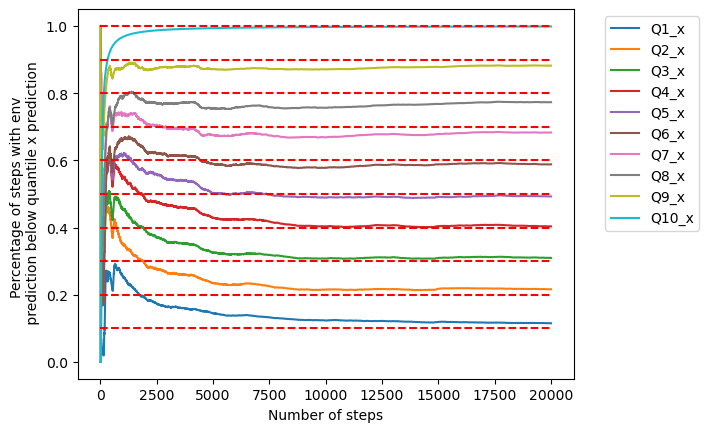

In [56]:
# x 
variable = "x"
nb_belowq1_list_x, nb_belowq2_list_x, nb_belowq3_list_x, nb_belowq4_list_x, nb_belowq5_list_x, nb_belowq6_list_x, nb_belowq7_list_x, nb_belowq8_list_x, nb_belowq9_list_x, nb_belowq10_list_x = nb_below_quantile(env_x, quantile0_x, quantile1_x, quantile2_x, quantile3_x, quantile4_x, quantile5_x, quantile6_x, quantile7_x, quantile8_x, quantile9_x, quantile10_x)
plot_nb_below_quantiles(prob, nb_belowq1_list_x, nb_belowq2_list_x, nb_belowq3_list_x, nb_belowq4_list_x, nb_belowq5_list_x, nb_belowq6_list_x, nb_belowq7_list_x, nb_belowq8_list_x, nb_belowq9_list_x, nb_belowq10_list_x, variable)



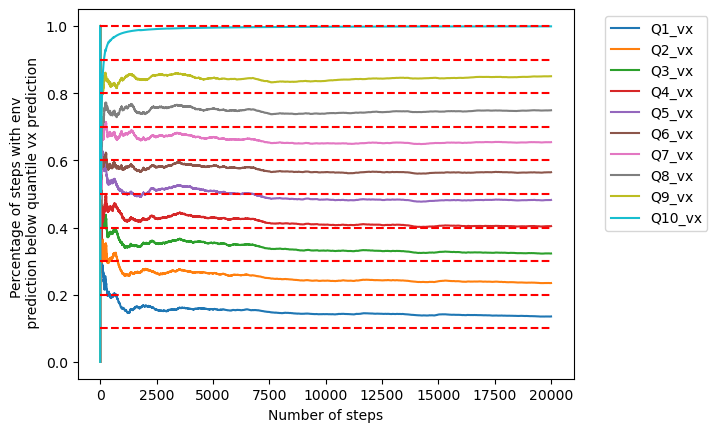

In [57]:
# vx
variable = "vx"
nb_belowq1_list_vx, nb_belowq2_list_vx, nb_belowq3_list_vx, nb_belowq4_list_vx, nb_belowq5_list_vx, nb_belowq6_list_vx, nb_belowq7_list_vx, nb_belowq8_list_vx, nb_belowq9_list_vx, nb_belowq10_list_vx = nb_below_quantile(env_vx, quantile0_vx, quantile1_vx, quantile2_vx, quantile3_vx, quantile4_vx, quantile5_vx, quantile6_vx, quantile7_vx, quantile8_vx, quantile9_vx, quantile10_vx)
plot_nb_below_quantiles(prob, nb_belowq1_list_vx, nb_belowq2_list_vx, nb_belowq3_list_vx, nb_belowq4_list_vx, nb_belowq5_list_vx, nb_belowq6_list_vx, nb_belowq7_list_vx, nb_belowq8_list_vx, nb_belowq9_list_vx, nb_belowq10_list_vx, variable)


Need to change the one below to y's


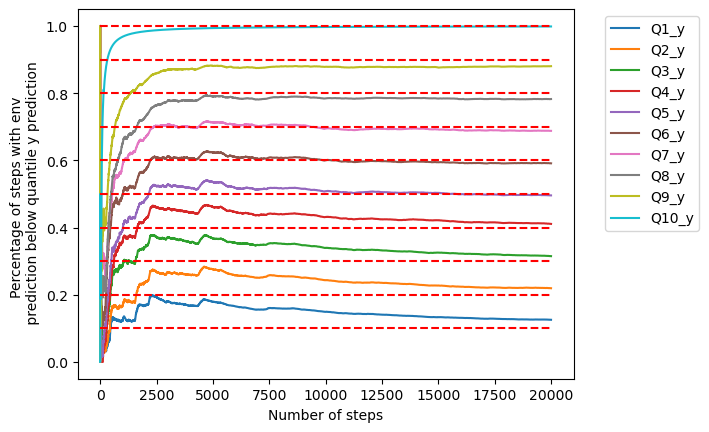

In [59]:
# y 
variable = "y"
nb_belowq1_list_y, nb_belowq2_list_y, nb_belowq3_list_y, nb_belowq4_list_y, nb_belowq5_list_y, nb_belowq6_list_y, nb_belowq7_list_y, nb_belowq8_list_y, nb_belowq9_list_y, nb_belowq10_list_y = nb_below_quantile(env_y, quantile0_y, quantile1_y, quantile2_y, quantile3_y, quantile4_y, quantile5_y, quantile6_y, quantile7_y, quantile8_y, quantile9_y, quantile10_y)
plot_nb_below_quantiles(prob, nb_belowq1_list_y, nb_belowq2_list_y, nb_belowq3_list_y, nb_belowq4_list_y, nb_belowq5_list_y, nb_belowq6_list_y, nb_belowq7_list_y, nb_belowq8_list_y, nb_belowq9_list_y, nb_belowq10_list_y, variable)


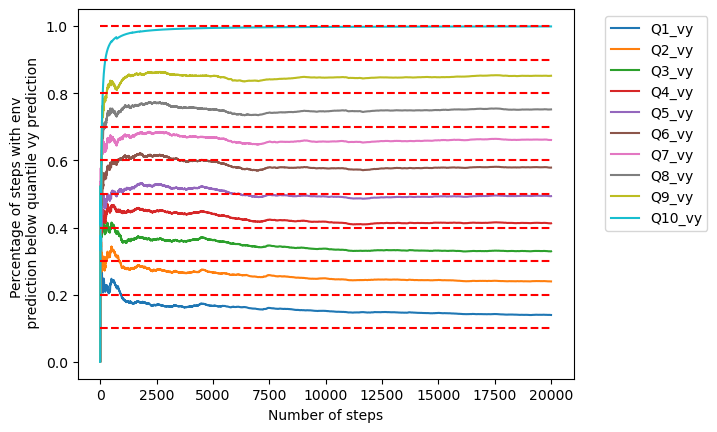

In [60]:
# vy
variable = "vy"
nb_belowq1_list_vy, nb_belowq2_list_vy, nb_belowq3_list_vy, nb_belowq4_list_vy, nb_belowq5_list_vy, nb_belowq6_list_vy, nb_belowq7_list_vy, nb_belowq8_list_vy, nb_belowq9_list_vy, nb_belowq10_list_vy = nb_below_quantile(env_vy, quantile0_vy, quantile1_vy, quantile2_vy, quantile3_vy, quantile4_vy, quantile5_vy, quantile6_vy, quantile7_vy, quantile8_vy, quantile9_vy, quantile10_vy)
plot_nb_below_quantiles(prob, nb_belowq1_list_vy, nb_belowq2_list_vy, nb_belowq3_list_vy, nb_belowq4_list_vy, nb_belowq5_list_vy, nb_belowq6_list_vy, nb_belowq7_list_vy, nb_belowq8_list_vy, nb_belowq9_list_vy, nb_belowq10_list_vy, variable)


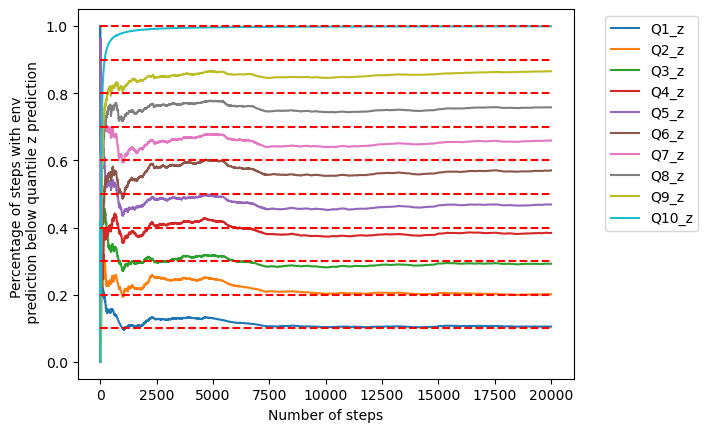

In [61]:
# z
variable = "z"
nb_belowq1_list_z, nb_belowq2_list_z, nb_belowq3_list_z, nb_belowq4_list_z, nb_belowq5_list_z, nb_belowq6_list_z, nb_belowq7_list_z, nb_belowq8_list_z, nb_belowq9_list_z, nb_belowq10_list_z = nb_below_quantile(env_z, quantile0_z, quantile1_z, quantile2_z, quantile3_z, quantile4_z, quantile5_z, quantile6_z, quantile7_z, quantile8_z, quantile9_z, quantile10_z)
plot_nb_below_quantiles(prob, nb_belowq1_list_z, nb_belowq2_list_z, nb_belowq3_list_z, nb_belowq4_list_z, nb_belowq5_list_z, nb_belowq6_list_z, nb_belowq7_list_z, nb_belowq8_list_z, nb_belowq9_list_z, nb_belowq10_list_z, variable)


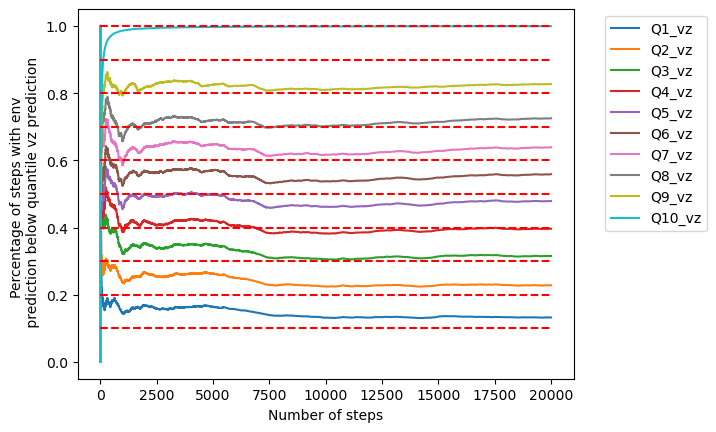

In [62]:
# vz
variable = "vz"
nb_belowq1_list_vz, nb_belowq2_list_vz, nb_belowq3_list_vz, nb_belowq4_list_vz, nb_belowq5_list_vz, nb_belowq6_list_vz, nb_belowq7_list_vz, nb_belowq8_list_vz, nb_belowq9_list_vz, nb_belowq10_list_vz = nb_below_quantile(env_vz, quantile0_vz, quantile1_vz, quantile2_vz, quantile3_vz, quantile4_vz, quantile5_vz, quantile6_vz, quantile7_vz, quantile8_vz, quantile9_vz, quantile10_vz)
plot_nb_below_quantiles(prob, nb_belowq1_list_vz, nb_belowq2_list_vz, nb_belowq3_list_vz, nb_belowq4_list_vz, nb_belowq5_list_vz, nb_belowq6_list_vz, nb_belowq7_list_vz, nb_belowq8_list_vz, nb_belowq9_list_vz, nb_belowq10_list_vz, variable)


## MuJoCo Reacher (2D)


In [63]:
prob = "MuJoCoReacher"

Run

In [64]:
seed = 0
env = gym.make('Reacher-v5').unwrapped # , render_mode='human'
# sim_env = gym.make('Reacher-v5').unwrapped  # Additional simulation model for MPC
# sim_env.reset(seed=seed)
env.reset(seed=seed)
# np.random.seed(seed)
# random.seed(seed)

error_magnitudes_cos1 = []
error_magnitudes_cos2 = []
error_magnitudes_sin1 = []
error_magnitudes_sin2 = []
error_magnitudes_omega1 = []
error_magnitudes_omega2 = []
error_magnitudes_xdist = []
error_magnitudes_ydist = []

env_cos1 = []
env_cos2 = []
env_sin1 = []
env_sin2 = []
env_omega1 = []
env_omega2 = []
env_xdist = []
env_ydist = []

pred_cos1 = []
pred_cos2 = []
pred_sin1 = []
pred_sin2 = []
pred_omega1 = []
pred_omega2 = []
pred_xdist = []
pred_ydist = []


# quantile 0 data
quantile0_cos1 = []
quantile0_cos2 = []
quantile0_sin1 = []
quantile0_sin2 = []
quantile0_omega1 = []
quantile0_omega2 = []
quantile0_xdist = []
quantile0_ydist = []

# quantile 1 data
quantile1_cos1 = []
quantile1_cos2 = []
quantile1_sin1 = []
quantile1_sin2 = []
quantile1_omega1 = []
quantile1_omega2 = []
quantile1_xdist = []
quantile1_ydist = []

# quantile 2 data
quantile2_cos1 = []
quantile2_cos2 = []
quantile2_sin1 = []
quantile2_sin2 = []
quantile2_omega1 = []
quantile2_omega2 = []
quantile2_xdist = []
quantile2_ydist = []

# quantile 3 data
quantile3_cos1 = []
quantile3_cos2 = []
quantile3_sin1 = []
quantile3_sin2 = []
quantile3_omega1 = []
quantile3_omega2 = []
quantile3_xdist = []
quantile3_ydist = []

# quantile 4 data
quantile4_cos1 = []
quantile4_cos2 = []
quantile4_sin1 = []
quantile4_sin2 = []
quantile4_omega1 = []
quantile4_omega2 = []
quantile4_xdist = []
quantile4_ydist = []

# quantile 5 data
quantile5_cos1 = []
quantile5_cos2 = []
quantile5_sin1 = []
quantile5_sin2 = []
quantile5_omega1 = []
quantile5_omega2 = []
quantile5_xdist = []
quantile5_ydist = []

# quantile 6 data
quantile6_cos1 = []
quantile6_cos2 = []
quantile6_sin1 = []
quantile6_sin2 = []
quantile6_omega1 = []
quantile6_omega2 = []
quantile6_xdist = []
quantile6_ydist = []

# quantile 7 data
quantile7_cos1 = []
quantile7_cos2 = []
quantile7_sin1 = []
quantile7_sin2 = []
quantile7_omega1 = []
quantile7_omega2 = []
quantile7_xdist = []
quantile7_ydist = []

# quantile 8 data
quantile8_cos1 = []
quantile8_cos2 = []
quantile8_sin1 = []
quantile8_sin2 = []
quantile8_omega1 = []
quantile8_omega2 = []
quantile8_xdist = []
quantile8_ydist = []

# quantile 9 data
quantile9_cos1 = []
quantile9_cos2 = []
quantile9_sin1 = []
quantile9_sin2 = []
quantile9_omega1 = []
quantile9_omega2 = []
quantile9_xdist = []
quantile9_ydist = []

# quantile 10 data
quantile10_cos1 = []
quantile10_cos2 = []
quantile10_sin1 = []
quantile10_sin2 = []
quantile10_omega1 = []
quantile10_omega2 = []
quantile10_xdist = []
quantile10_ydist = []


actions_lows = env.action_space.low#[:3]
actions_highs = env.action_space.high#[:3]
states_low = torch.tensor([-1, -1, -1, -1, -100, -100, -torch.inf, -torch.inf])
states_high = torch.tensor([1, 1, 1, 1, 100, 100, torch.inf, torch.inf])
state_dim = 8
action_dim = len(actions_lows)

# # Hyperparameters
# state_dim = len(states_low)
# action_dim = len(actions_low)
# Define your quantiles (e.g., 0.1, 0.3, 0.7, 0.9)
# quantiles = torch.tensor([0.1, 0.3, 0.7, 0.9], dtype=torch.float32)
quantiles = torch.tensor(np.array([0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), dtype=torch.float32)

# num_quantiles = 4  # Example with 4 quantiles
num_quantiles = len(quantiles)

# Initialize the Next-State Prediction Network
model = NextStateQuantileNetwork(state_dim, action_dim, num_quantiles)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Experience replay buffer
replay_buffer = []

batch_size = 32


num_test_steps = 20000
state, _ = env.reset(seed=seed)
episode_reward = 0
actions_list = []
done = False
truncated = False

# goal_state = state['desired_goal'] # 3 components
# state = state['observation']#[:3] # 6 components

actions_taken = np.zeros((num_test_steps, action_dim))
env.action_space.seed(seed)
discrete = False

goal_state = np.array([state[4], state[5]])
state = np.array([state[0], state[1], state[2], state[3], state[6], state[7], state[8], state[9]])

for step in range(num_test_steps):
    action = env.action_space.sample()
    actions_taken[step] = action
    
    next_state, reward, done, truncated, info = env.step(action)
    episode_reward += reward
    # next_state = next_state['observation']#[:3] # env.state
    goal_state = np.array([next_state[4], next_state[5]])
    next_state = np.array([next_state[0], next_state[1], next_state[2], next_state[3], next_state[6], next_state[7], next_state[8], next_state[9]])
    
    if step >= 1:
        # test_env = env.copy()
        # test_action = test_env.action_space.sample()
        # test_next_state, _, _, _, _ = test_env.step(test_action)
        # test_next_state = test_next_state['observation'][:3]
        
        test_next_state = torch.tensor(next_state, dtype=torch.float32)
        
        if discrete:
            test_action = torch.tensor(np.array([action]), dtype=torch.float32)#.unsqueeze(1)  # Example action
        else:
            test_action = torch.tensor(action, dtype=torch.float32)#.unsqueeze(1)
        test_state = torch.tensor(state, dtype=torch.float32)#.reshape(1, -1)
        test_state = torch.clip(test_state, states_low, states_high)

        # Predict next state quantiles
        predicted_quantiles = model(test_state, test_action)  # Shape: (1, num_quantiles, state_dim)
        lower_quantile = predicted_quantiles[:, 0, :]  # Shape: (1, state_dim)
        mid_quantile = predicted_quantiles[:, int(num_quantiles/2), :].detach().numpy()  # Shape: (1, state_dim)
        upper_quantile = predicted_quantiles[:, -1, :]  # Shape: (1, state_dim)
        # print("predicted_quantiles ", predicted_quantiles, "\n")
        # print("Lower Quantile:", lower_quantile, "\n")
        # print("Mid Quantile:", mid_quantile, "\n")
        # print("Upper Quantile:", upper_quantile, "\n")
        
        pred_cos1 = np.append(pred_cos1, mid_quantile[0][0])
        pred_cos2 = np.append(pred_cos2, mid_quantile[0][1])
        pred_sin1 = np.append(pred_sin1, mid_quantile[0][2])
        pred_sin2 = np.append(pred_sin2, mid_quantile[0][3])
        pred_omega1 = np.append(pred_omega1, mid_quantile[0][4])
        pred_omega2 = np.append(pred_omega2, mid_quantile[0][5])
        pred_xdist = np.append(pred_xdist, mid_quantile[0][6])
        pred_ydist = np.append(pred_ydist, mid_quantile[0][7])
    
        # Quantile 0 data
        quantile0_cos1 = np.append(quantile0_cos1, predicted_quantiles[0][0][0].item())
        quantile0_cos2 = np.append(quantile0_cos2, predicted_quantiles[0][0][1].item())
        quantile0_sin1 = np.append(quantile0_sin1, predicted_quantiles[0][0][2].item())
        quantile0_sin2 = np.append(quantile0_sin2, predicted_quantiles[0][0][3].item())
        quantile0_omega1 = np.append(quantile0_omega1, predicted_quantiles[0][0][4].item())
        quantile0_omega2 = np.append(quantile0_omega2, predicted_quantiles[0][0][5].item())
        quantile0_xdist = np.append(quantile0_xdist, predicted_quantiles[0][0][6].item())
        quantile0_ydist = np.append(quantile0_ydist, predicted_quantiles[0][0][7].item())
        
        # Quantile 1 data
        quantile1_cos1 = np.append(quantile1_cos1, predicted_quantiles[0][1][0].item())
        quantile1_cos2 = np.append(quantile1_cos2, predicted_quantiles[0][1][1].item())
        quantile1_sin1 = np.append(quantile1_sin1, predicted_quantiles[0][1][2].item())
        quantile1_sin2 = np.append(quantile1_sin2, predicted_quantiles[0][1][3].item())
        quantile1_omega1 = np.append(quantile1_omega1, predicted_quantiles[0][1][4].item())
        quantile1_omega2 = np.append(quantile1_omega2, predicted_quantiles[0][1][5].item())
        quantile1_xdist = np.append(quantile1_xdist, predicted_quantiles[0][1][6].item())
        quantile1_ydist = np.append(quantile1_ydist, predicted_quantiles[0][1][7].item())
        
        # Quantile 2 data
        quantile2_cos1 = np.append(quantile2_cos1, predicted_quantiles[0][2][0].item())
        quantile2_cos2 = np.append(quantile2_cos2, predicted_quantiles[0][2][1].item())
        quantile2_sin1 = np.append(quantile2_sin1, predicted_quantiles[0][2][2].item())
        quantile2_sin2 = np.append(quantile2_sin2, predicted_quantiles[0][2][3].item())
        quantile2_omega1 = np.append(quantile2_omega1, predicted_quantiles[0][2][4].item())
        quantile2_omega2 = np.append(quantile2_omega2, predicted_quantiles[0][2][5].item())
        quantile2_xdist = np.append(quantile2_xdist, predicted_quantiles[0][2][6].item())
        quantile2_ydist = np.append(quantile2_ydist, predicted_quantiles[0][2][7].item())
        
        # Quantile 3 data
        quantile3_cos1 = np.append(quantile3_cos1, predicted_quantiles[0][3][0].item())
        quantile3_cos2 = np.append(quantile3_cos2, predicted_quantiles[0][3][1].item())
        quantile3_sin1 = np.append(quantile3_sin1, predicted_quantiles[0][3][2].item())
        quantile3_sin2 = np.append(quantile3_sin2, predicted_quantiles[0][3][3].item())
        quantile3_omega1 = np.append(quantile3_omega1, predicted_quantiles[0][3][4].item())
        quantile3_omega2 = np.append(quantile3_omega2, predicted_quantiles[0][3][5].item())
        quantile3_xdist = np.append(quantile3_xdist, predicted_quantiles[0][3][6].item())
        quantile3_ydist = np.append(quantile3_ydist, predicted_quantiles[0][3][7].item())
        
        # Quantile 4 data
        quantile4_cos1 = np.append(quantile4_cos1, predicted_quantiles[0][4][0].item())
        quantile4_cos2 = np.append(quantile4_cos2, predicted_quantiles[0][4][1].item())
        quantile4_sin1 = np.append(quantile4_sin1, predicted_quantiles[0][4][2].item())
        quantile4_sin2 = np.append(quantile4_sin2, predicted_quantiles[0][4][3].item())
        quantile4_omega1 = np.append(quantile4_omega1, predicted_quantiles[0][4][4].item())
        quantile4_omega2 = np.append(quantile4_omega2, predicted_quantiles[0][4][5].item())
        quantile4_xdist = np.append(quantile4_xdist, predicted_quantiles[0][4][6].item())
        quantile4_ydist = np.append(quantile4_ydist, predicted_quantiles[0][4][7].item())
        
        # Quantile 5 data
        quantile5_cos1 = np.append(quantile5_cos1, predicted_quantiles[0][5][0].item())
        quantile5_cos2 = np.append(quantile5_cos2, predicted_quantiles[0][5][1].item())
        quantile5_sin1 = np.append(quantile5_sin1, predicted_quantiles[0][5][2].item())
        quantile5_sin2 = np.append(quantile5_sin2, predicted_quantiles[0][5][3].item())
        quantile5_omega1 = np.append(quantile5_omega1, predicted_quantiles[0][5][4].item())
        quantile5_omega2 = np.append(quantile5_omega2, predicted_quantiles[0][5][5].item())
        quantile5_xdist = np.append(quantile5_xdist, predicted_quantiles[0][5][6].item())
        quantile5_ydist = np.append(quantile5_ydist, predicted_quantiles[0][5][7].item())
        
        # Quantile 6 data
        quantile6_cos1 = np.append(quantile6_cos1, predicted_quantiles[0][6][0].item())
        quantile6_cos2 = np.append(quantile6_cos2, predicted_quantiles[0][6][1].item())
        quantile6_sin1 = np.append(quantile6_sin1, predicted_quantiles[0][6][2].item())
        quantile6_sin2 = np.append(quantile6_sin2, predicted_quantiles[0][6][3].item())
        quantile6_omega1 = np.append(quantile6_omega1, predicted_quantiles[0][6][4].item())
        quantile6_omega2 = np.append(quantile6_omega2, predicted_quantiles[0][6][5].item())
        quantile6_xdist = np.append(quantile6_xdist, predicted_quantiles[0][6][6].item())
        quantile6_ydist = np.append(quantile6_ydist, predicted_quantiles[0][6][7].item())
        
        # Quantile 7 data
        quantile7_cos1 = np.append(quantile7_cos1, predicted_quantiles[0][7][0].item())
        quantile7_cos2 = np.append(quantile7_cos2, predicted_quantiles[0][7][1].item())
        quantile7_sin1 = np.append(quantile7_sin1, predicted_quantiles[0][7][2].item())
        quantile7_sin2 = np.append(quantile7_sin2, predicted_quantiles[0][7][3].item())
        quantile7_omega1 = np.append(quantile7_omega1, predicted_quantiles[0][7][4].item())
        quantile7_omega2 = np.append(quantile7_omega2, predicted_quantiles[0][7][5].item())
        quantile7_xdist = np.append(quantile7_xdist, predicted_quantiles[0][7][6].item())
        quantile7_ydist = np.append(quantile7_ydist, predicted_quantiles[0][7][7].item())
        
        # Quantile 8 data
        quantile8_cos1 = np.append(quantile8_cos1, predicted_quantiles[0][8][0].item())
        quantile8_cos2 = np.append(quantile8_cos2, predicted_quantiles[0][8][1].item())
        quantile8_sin1 = np.append(quantile8_sin1, predicted_quantiles[0][8][2].item())
        quantile8_sin2 = np.append(quantile8_sin2, predicted_quantiles[0][8][3].item())
        quantile8_omega1 = np.append(quantile8_omega1, predicted_quantiles[0][8][4].item())
        quantile8_omega2 = np.append(quantile8_omega2, predicted_quantiles[0][8][5].item())
        quantile8_xdist = np.append(quantile8_xdist, predicted_quantiles[0][8][6].item())
        quantile8_ydist = np.append(quantile8_ydist, predicted_quantiles[0][8][7].item())
        
        # Quantile 9 data
        quantile9_cos1 = np.append(quantile9_cos1, predicted_quantiles[0][9][0].item())
        quantile9_cos2 = np.append(quantile9_cos2, predicted_quantiles[0][9][1].item())
        quantile9_sin1 = np.append(quantile9_sin1, predicted_quantiles[0][9][2].item())
        quantile9_sin2 = np.append(quantile9_sin2, predicted_quantiles[0][9][3].item())
        quantile9_omega1 = np.append(quantile9_omega1, predicted_quantiles[0][9][4].item())
        quantile9_omega2 = np.append(quantile9_omega2, predicted_quantiles[0][9][5].item())
        quantile9_xdist = np.append(quantile9_xdist, predicted_quantiles[0][9][6].item())
        quantile9_ydist = np.append(quantile9_ydist, predicted_quantiles[0][9][7].item())
        
        # Quantile 10 data
        quantile10_cos1 = np.append(quantile10_cos1, predicted_quantiles[0][10][0].item())
        quantile10_cos2 = np.append(quantile10_cos2, predicted_quantiles[0][10][1].item())
        quantile10_sin1 = np.append(quantile10_sin1, predicted_quantiles[0][10][2].item())
        quantile10_sin2 = np.append(quantile10_sin2, predicted_quantiles[0][10][3].item())
        quantile10_omega1 = np.append(quantile10_omega1, predicted_quantiles[0][10][4].item())
        quantile10_omega2 = np.append(quantile10_omega2, predicted_quantiles[0][10][5].item())
        quantile10_xdist = np.append(quantile10_xdist, predicted_quantiles[0][10][6].item())
        quantile10_ydist = np.append(quantile10_ydist, predicted_quantiles[0][10][7].item())
        
        delta_cos1 = test_next_state[0] - mid_quantile[0][0]
        delta_cos2 = test_next_state[1] - mid_quantile[0][1]
        delta_sin1 = test_next_state[2] - mid_quantile[0][2]
        delta_sin2 = test_next_state[3] - mid_quantile[0][3]
        delta_omega1 = test_next_state[4] - mid_quantile[0][4]
        delta_omega2 = test_next_state[5] - mid_quantile[0][5]
        delta_xdist = test_next_state[6] - mid_quantile[0][6]
        delta_ydist = test_next_state[7] - mid_quantile[0][7]
        
        error_magnitudes_cos1.append(np.abs(delta_cos1)) # .detach().numpy()
        error_magnitudes_cos2.append(np.abs(delta_cos2)) # .detach().numpy()
        error_magnitudes_sin1.append(np.abs(delta_sin1)) # .detach().numpy()
        error_magnitudes_sin2.append(np.abs(delta_sin2)) # .detach().numpy()
        error_magnitudes_omega1.append(np.abs(delta_omega1)) # .detach().numpy()
        error_magnitudes_omega2.append(np.abs(delta_omega2)) # .detach().numpy()
        error_magnitudes_xdist.append(np.abs(delta_xdist)) # .detach().numpy()
        error_magnitudes_ydist.append(np.abs(delta_ydist)) # .detach().numpy()
        
        env_cos1.append(test_next_state[0])
        env_cos2.append(test_next_state[1])
        env_sin1.append(test_next_state[2])
        env_sin2.append(test_next_state[3])
        env_omega1.append(test_next_state[4])
        env_omega2.append(test_next_state[5])
        env_xdist.append(test_next_state[6])
        env_ydist.append(test_next_state[7])
    
    # next_state = env.state.copy()
    # Store experience in replay buffer
    replay_buffer.append((state, action, reward, next_state, done))
    if len(replay_buffer) < batch_size:
        pass
    else:
        batch = random.sample(replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        states = torch.clip(states, states_low, states_high)
        
        # Predict next state quantiles
        predicted_quantiles = model(states, actions)  # Shape: (batch_size, num_quantiles, state_dim)
        
        # Use next state as target (can be improved with target policy)
        target_quantiles = next_states
        
        # Compute the target quantiles (e.g., replicate next state across the quantile dimension)
        # target_quantiles = next_states.unsqueeze(-1).repeat(1, 1, num_quantiles)

        # Compute Quantile Huber Loss
        loss = quantile_huber_loss(predicted_quantiles, target_quantiles, quantiles)

        
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    state = next_state

    if done or truncated:
        state, _ = env.reset(seed=seed)
        episode_reward = 0
        actions_list = []
        done = False
        truncated = False
        
        goal_state = np.array([state[4], state[5]])
        state = np.array([state[0], state[1], state[2], state[3], state[6], state[7], state[8], state[9]])


Graphs

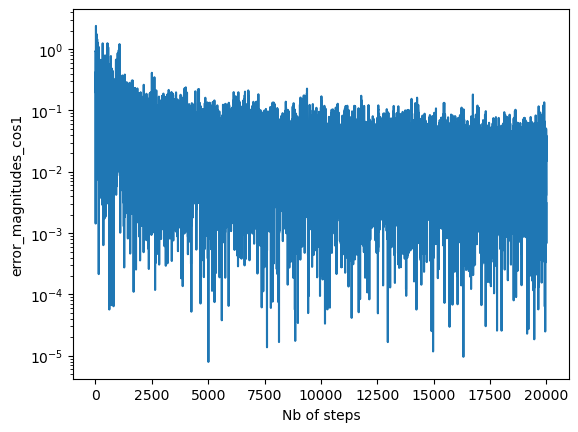

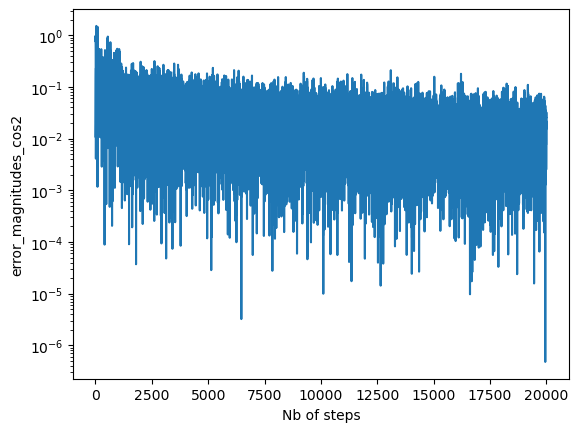

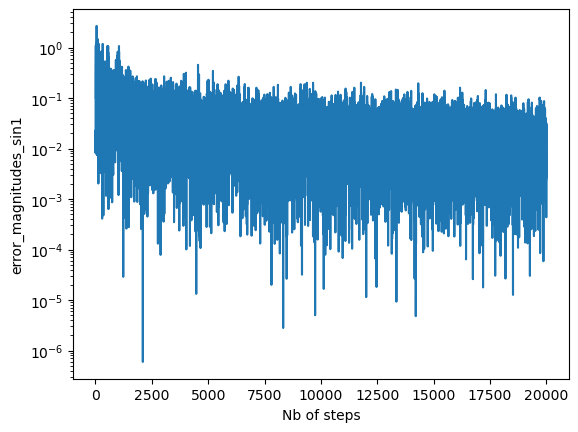

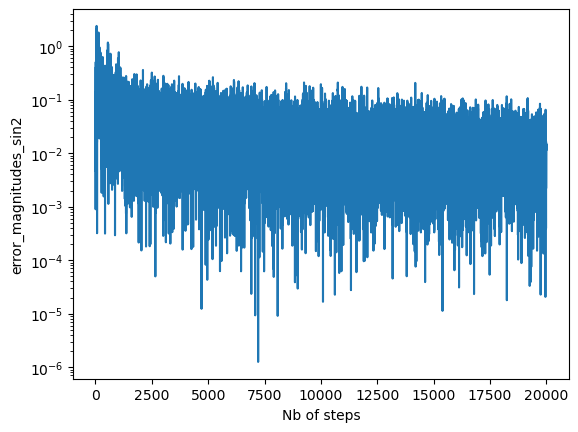

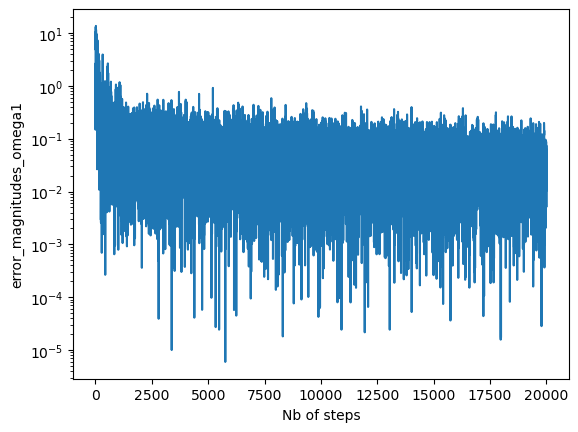

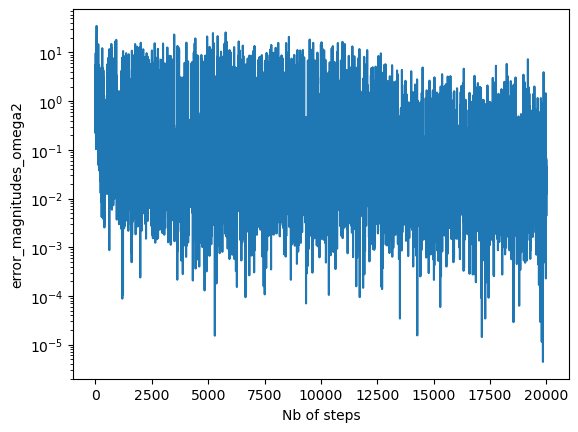

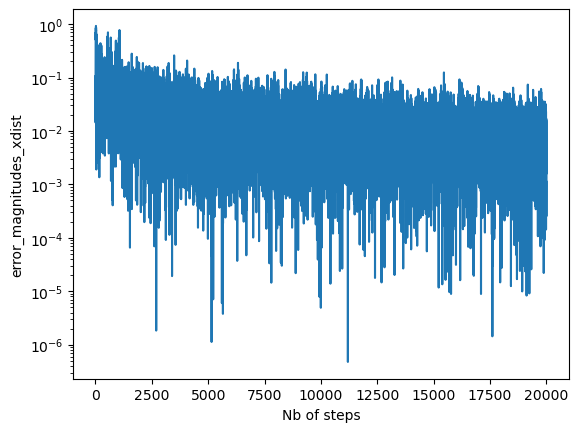

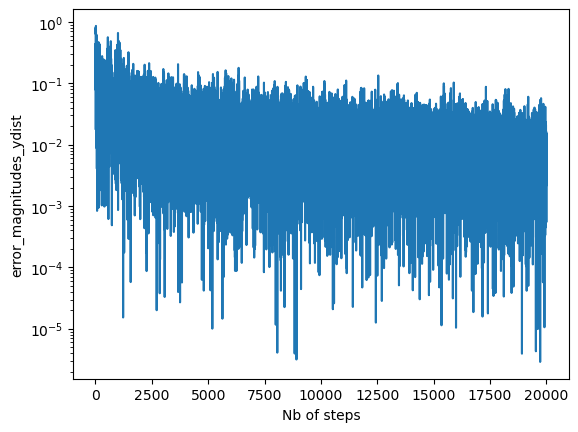

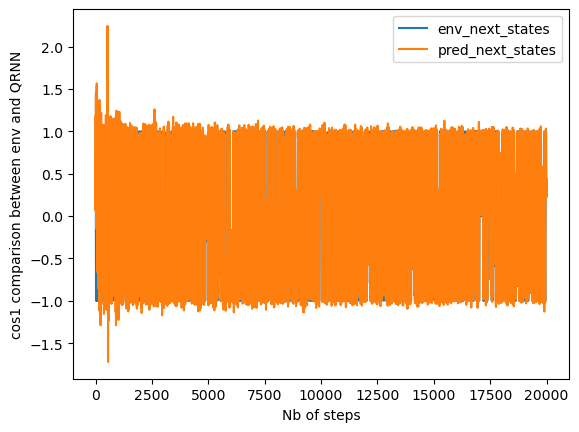

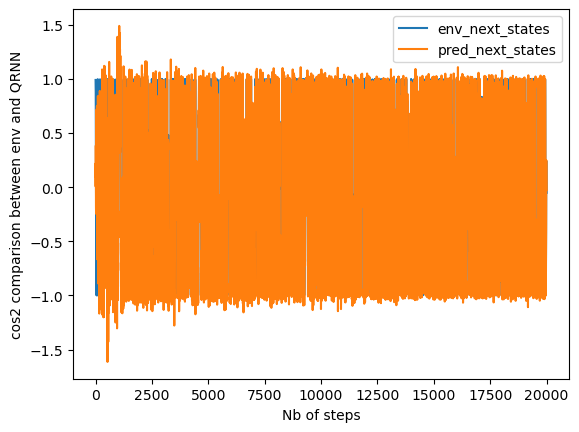

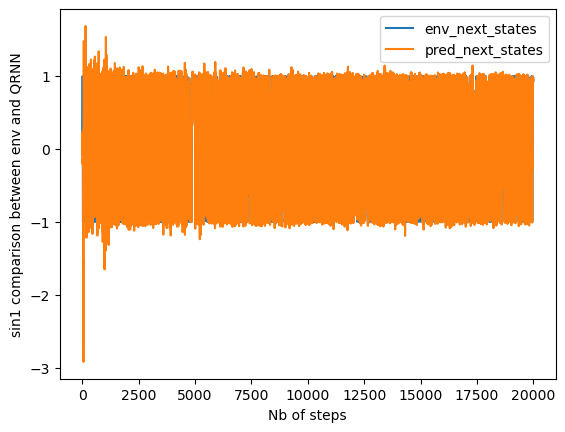

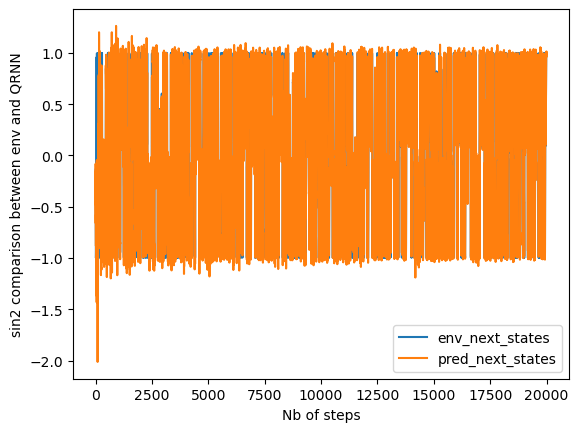

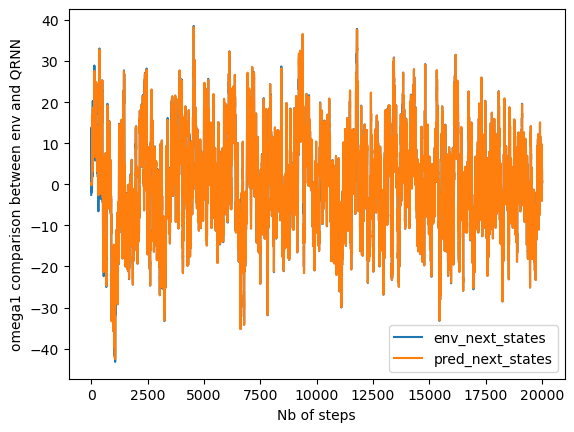

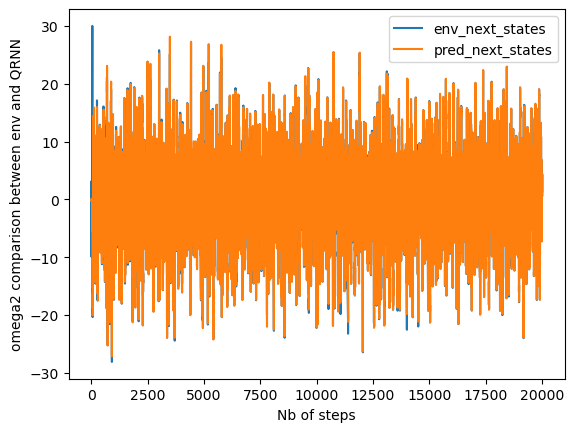

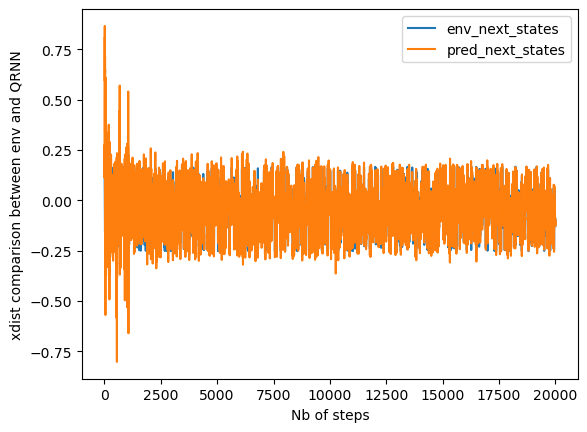

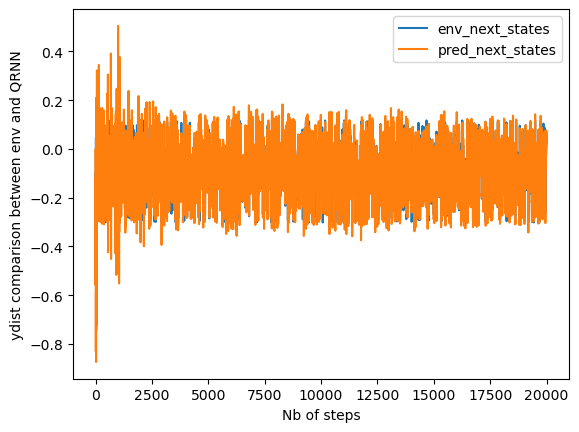

In [65]:
%matplotlib inline

import matplotlib.pyplot as plt
# Plot the rewards
# plt.figure(1)
# # plt.legend()
# # plt.grid()
# plt.plot(episode_reward_list)
# plt.xlabel('Nb of episodes')
# plt.ylabel('episode reward')
# # plt.title('MPC_Pendulum with Optimized Action Sequences')
# # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\Graphs\\episode_rewards_withCPUforQRNN_{timestamp}.png')
# # # plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\episode_rewards_withGPUforGP_{timestamp}.png')
# plt.yscale('log')

plt.figure(2)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_cos1)
plt.ylabel('error_magnitudes_cos1')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(3)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_cos2)
plt.ylabel('error_magnitudes_cos2')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(4)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_sin1)
plt.ylabel('error_magnitudes_sin1')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(5)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_sin2)
plt.ylabel('error_magnitudes_sin2')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(6)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_omega1)
plt.ylabel('error_magnitudes_omega1')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(7)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_omega2)
plt.ylabel('error_magnitudes_omega2')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(8)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_xdist)
plt.ylabel('error_magnitudes_xdist')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_1_{timestamp}.png')
plt.yscale('log')

plt.figure(9)
plt.xlabel('Nb of steps')
plt.plot(error_magnitudes_ydist)
plt.ylabel('error_magnitudes_ydist')
# plt.title('Error magnitude btw env.state and GP predicted state per step')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\error_magnitudes_2_{timestamp}.png')
plt.yscale('log')

plt.figure(10)
plt.xlabel('Nb of steps')
plt.ylabel('cos1 comparison between env and QRNN')
plt.plot(env_cos1, label='env_next_states')
plt.plot(pred_cos1, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.yscale('log')
plt.legend()

plt.figure(11)
plt.xlabel('Nb of steps')
plt.ylabel('cos2 comparison between env and QRNN')
plt.plot(env_cos2, label='env_next_states')
plt.plot(pred_cos2, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.yscale('log')
plt.legend()

plt.figure(12)
plt.xlabel('Nb of steps')
plt.ylabel('sin1 comparison between env and QRNN')
plt.plot(env_sin1, label='env_next_states')
plt.plot(pred_sin1, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
# plt.yscale('log')
plt.legend()

plt.figure(13)
plt.xlabel('Nb of steps')
plt.ylabel('sin2 comparison between env and QRNN')
plt.plot(env_sin2, label='env_next_states')
plt.plot(pred_sin2, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
# plt.yscale('log')
plt.legend()

plt.figure(14)
plt.xlabel('Nb of steps')
plt.ylabel('omega1 comparison between env and QRNN')
plt.plot(env_omega1, label='env_next_states')
plt.plot(pred_omega1, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(15)
plt.xlabel('Nb of steps')
plt.ylabel('omega2 comparison between env and QRNN')
plt.plot(env_omega2, label='env_next_states')
plt.plot(pred_omega2, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(16)
plt.xlabel('Nb of steps')
plt.ylabel('xdist comparison between env and QRNN')
plt.plot(env_xdist, label='env_next_states')
plt.plot(pred_xdist, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_1std, pred_x + pred_x_top_2std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_x)), pred_x - pred_x_bottom_2std, pred_x + pred_x_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\angles_comparison_GP_env_{timestamp}.png')
plt.legend()

plt.figure(17)
plt.xlabel('Nb of steps')
plt.ylabel('ydist comparison between env and QRNN')
plt.plot(env_ydist, label='env_next_states')
plt.plot(pred_ydist, label='pred_next_states')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_1std, pred_y + pred_y_top_1std, alpha=0.5, label='1 std', color='green')
# plt.fill_between(np.arange(len(pred_y)), pred_y - pred_y_bottom_2std, pred_y + pred_y_top_2std, alpha=0.5, label='2 std', color='red')
# plt.savefig(f'C:\\Users\\nicle\\Desktop\\GPBO-MBRL\\GP-MPC_NL\\PF_MPC_GP_Env\\ParallelOverParticles\\omegas_comparison_GP_env_{timestamp}.png')
plt.legend()


Graph of number of values below the different quantiles


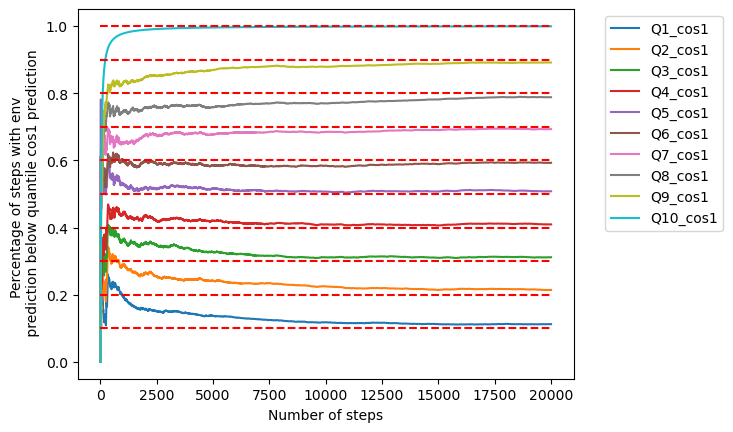

In [66]:
# cos1 
variable = "cos1"
nb_belowq1_list_cos1, nb_below_q2_list_cos1, nb_below_q3_list_cos1, nb_below_q4_list_cos1, nb_below_q5_list_cos1, nb_below_q6_list_cos1, nb_below_q7_list_cos1, nb_below_q8_list_cos1, nb_below_q9_list_cos1, nb_below_q10_list_cos1 = nb_below_quantile(env_cos1, quantile0_cos1, quantile1_cos1, quantile2_cos1, quantile3_cos1, quantile4_cos1, quantile5_cos1, quantile6_cos1, quantile7_cos1, quantile8_cos1, quantile9_cos1, quantile10_cos1)
plot_nb_below_quantiles(prob, nb_belowq1_list_cos1, nb_below_q2_list_cos1, nb_below_q3_list_cos1, nb_below_q4_list_cos1, nb_below_q5_list_cos1, nb_below_q6_list_cos1, nb_below_q7_list_cos1, nb_below_q8_list_cos1, nb_below_q9_list_cos1, nb_below_q10_list_cos1, variable)


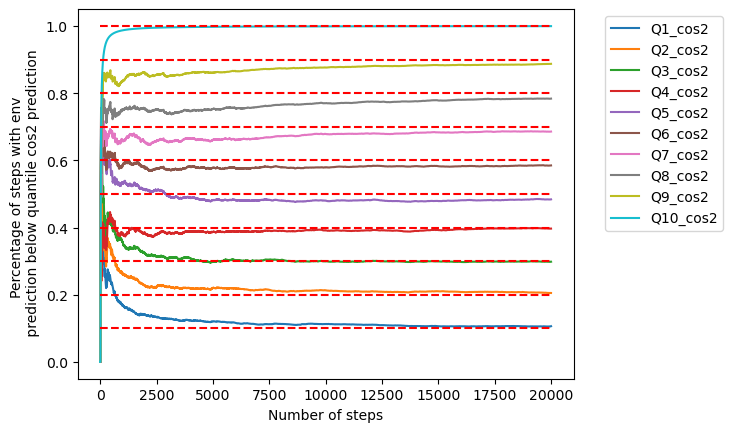

In [67]:
# cos2
variable = "cos2"
nb_belowq1_list_cos2, nb_below_q2_list_cos2, nb_below_q3_list_cos2, nb_below_q4_list_cos2, nb_below_q5_list_cos2, nb_below_q6_list_cos2, nb_below_q7_list_cos2, nb_below_q8_list_cos2, nb_below_q9_list_cos2, nb_below_q10_list_cos2 = nb_below_quantile(env_cos2, quantile0_cos2, quantile1_cos2, quantile2_cos2, quantile3_cos2, quantile4_cos2, quantile5_cos2, quantile6_cos2, quantile7_cos2, quantile8_cos2, quantile9_cos2, quantile10_cos2)
plot_nb_below_quantiles(prob, nb_belowq1_list_cos2, nb_below_q2_list_cos2, nb_below_q3_list_cos2, nb_below_q4_list_cos2, nb_below_q5_list_cos2, nb_below_q6_list_cos2, nb_below_q7_list_cos2, nb_below_q8_list_cos2, nb_below_q9_list_cos2, nb_below_q10_list_cos2, variable)


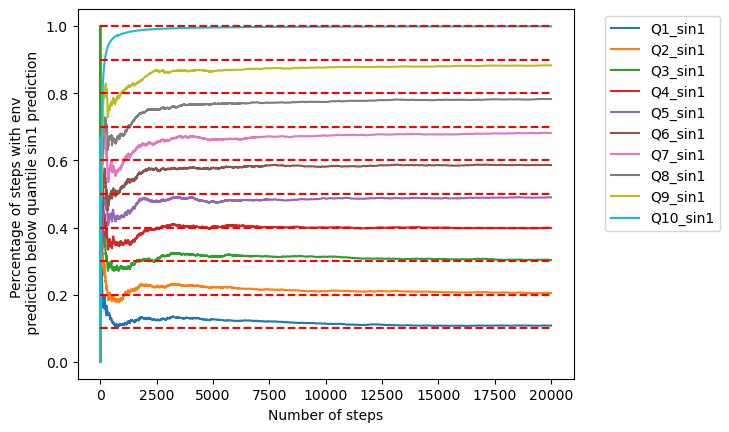

In [68]:
# sin1
variable = "sin1"
nb_belowq1_list_sin1, nb_below_q2_list_sin1, nb_below_q3_list_sin1, nb_below_q4_list_sin1, nb_below_q5_list_sin1, nb_below_q6_list_sin1, nb_below_q7_list_sin1, nb_below_q8_list_sin1, nb_below_q9_list_sin1, nb_below_q10_list_sin1 = nb_below_quantile(env_sin1, quantile0_sin1, quantile1_sin1, quantile2_sin1, quantile3_sin1, quantile4_sin1, quantile5_sin1, quantile6_sin1, quantile7_sin1, quantile8_sin1, quantile9_sin1, quantile10_sin1)
plot_nb_below_quantiles(prob, nb_belowq1_list_sin1, nb_below_q2_list_sin1, nb_below_q3_list_sin1, nb_below_q4_list_sin1, nb_below_q5_list_sin1, nb_below_q6_list_sin1, nb_below_q7_list_sin1, nb_below_q8_list_sin1, nb_below_q9_list_sin1, nb_below_q10_list_sin1, variable)


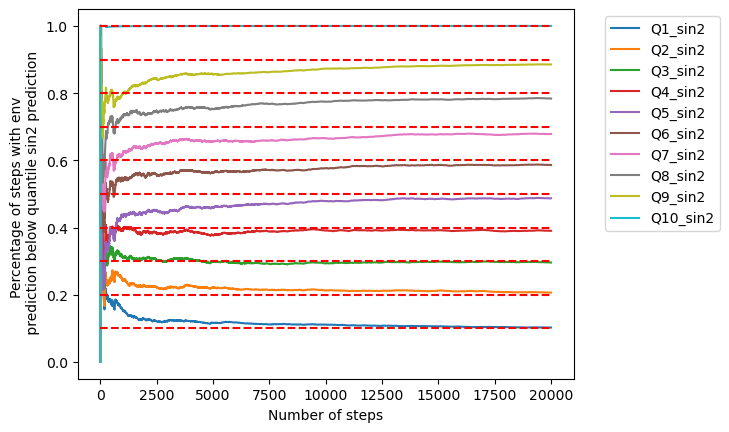

In [69]:
# sin2
variable = "sin2"
nb_belowq1_list_sin2, nb_below_q2_list_sin2, nb_below_q3_list_sin2, nb_below_q4_list_sin2, nb_below_q5_list_sin2, nb_below_q6_list_sin2, nb_below_q7_list_sin2, nb_below_q8_list_sin2, nb_below_q9_list_sin2, nb_below_q10_list_sin2 = nb_below_quantile(env_sin2, quantile0_sin2, quantile1_sin2, quantile2_sin2, quantile3_sin2, quantile4_sin2, quantile5_sin2, quantile6_sin2, quantile7_sin2, quantile8_sin2, quantile9_sin2, quantile10_sin2)
plot_nb_below_quantiles(prob, nb_belowq1_list_sin2, nb_below_q2_list_sin2, nb_below_q3_list_sin2, nb_below_q4_list_sin2, nb_below_q5_list_sin2, nb_below_q6_list_sin2, nb_below_q7_list_sin2, nb_below_q8_list_sin2, nb_below_q9_list_sin2, nb_below_q10_list_sin2, variable)


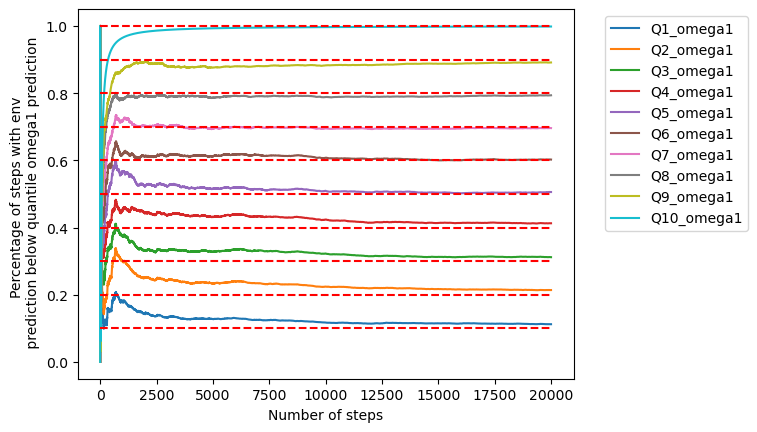

In [70]:
# omega1
variable = "omega1"
nb_belowq1_list_omega1, nb_below_q2_list_omega1, nb_below_q3_list_omega1, nb_below_q4_list_omega1, nb_below_q5_list_omega1, nb_below_q6_list_omega1, nb_below_q7_list_omega1, nb_below_q8_list_omega1, nb_below_q9_list_omega1, nb_below_q10_list_omega1 = nb_below_quantile(env_omega1, quantile0_omega1, quantile1_omega1, quantile2_omega1, quantile3_omega1, quantile4_omega1, quantile5_omega1, quantile6_omega1, quantile7_omega1, quantile8_omega1, quantile9_omega1, quantile10_omega1)
plot_nb_below_quantiles(prob, nb_belowq1_list_omega1, nb_below_q2_list_omega1, nb_below_q3_list_omega1, nb_below_q4_list_omega1, nb_below_q5_list_omega1, nb_below_q6_list_omega1, nb_below_q7_list_omega1, nb_below_q8_list_omega1, nb_below_q9_list_omega1, nb_below_q10_list_omega1, variable)


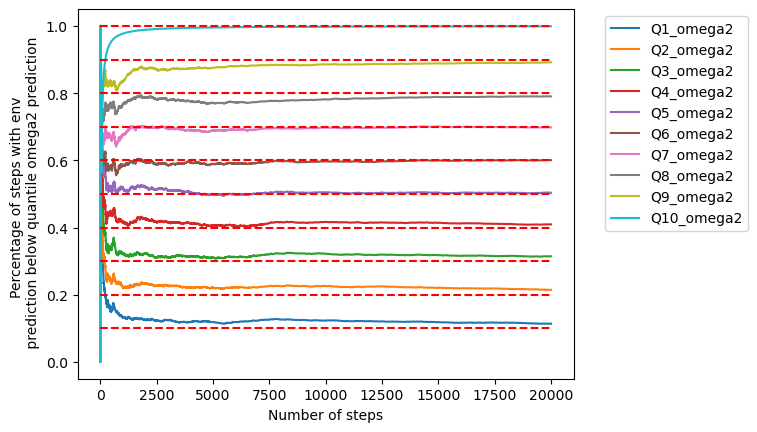

In [71]:
# omega2
variable = "omega2"
nb_belowq1_list_omega2, nb_below_q2_list_omega2, nb_below_q3_list_omega2, nb_below_q4_list_omega2, nb_below_q5_list_omega2, nb_below_q6_list_omega2, nb_below_q7_list_omega2, nb_below_q8_list_omega2, nb_below_q9_list_omega2, nb_below_q10_list_omega2 = nb_below_quantile(env_omega2, quantile0_omega2, quantile1_omega2, quantile2_omega2, quantile3_omega2, quantile4_omega2, quantile5_omega2, quantile6_omega2, quantile7_omega2, quantile8_omega2, quantile9_omega2, quantile10_omega2)
plot_nb_below_quantiles(prob, nb_belowq1_list_omega2, nb_below_q2_list_omega2, nb_below_q3_list_omega2, nb_below_q4_list_omega2, nb_below_q5_list_omega2, nb_below_q6_list_omega2, nb_below_q7_list_omega2, nb_below_q8_list_omega2, nb_below_q9_list_omega2, nb_below_q10_list_omega2, variable)


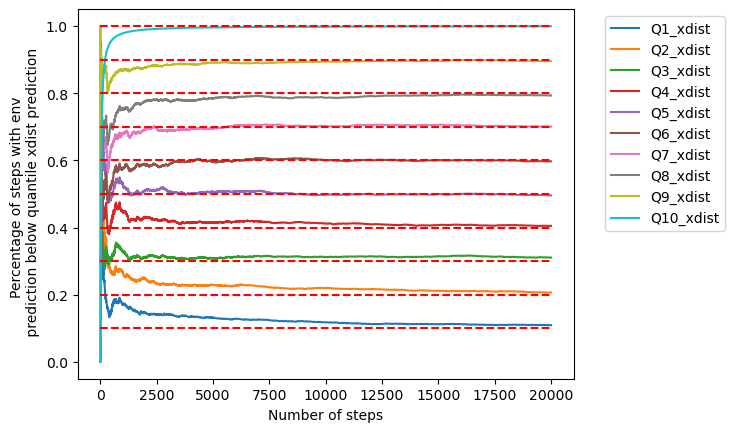

In [72]:
# xdist
variable = "xdist"
nb_belowq1_list_xdist, nb_below_q2_list_xdist, nb_below_q3_list_xdist, nb_below_q4_list_xdist, nb_below_q5_list_xdist, nb_below_q6_list_xdist, nb_below_q7_list_xdist, nb_below_q8_list_xdist, nb_below_q9_list_xdist, nb_below_q10_list_xdist = nb_below_quantile(env_xdist, quantile0_xdist, quantile1_xdist, quantile2_xdist, quantile3_xdist, quantile4_xdist, quantile5_xdist, quantile6_xdist, quantile7_xdist, quantile8_xdist, quantile9_xdist, quantile10_xdist)
plot_nb_below_quantiles(prob, nb_belowq1_list_xdist, nb_below_q2_list_xdist, nb_below_q3_list_xdist, nb_below_q4_list_xdist, nb_below_q5_list_xdist, nb_below_q6_list_xdist, nb_below_q7_list_xdist, nb_below_q8_list_xdist, nb_below_q9_list_xdist, nb_below_q10_list_xdist, variable)


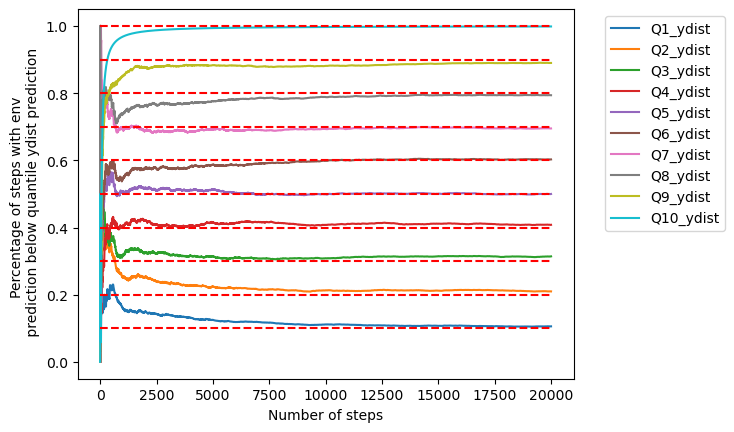

In [73]:
# ydist 
variable = "ydist"
nb_belowq1_list_ydist, nb_below_q2_list_ydist, nb_below_q3_list_ydist, nb_below_q4_list_ydist, nb_below_q5_list_ydist, nb_below_q6_list_ydist, nb_below_q7_list_ydist, nb_below_q8_list_ydist, nb_below_q9_list_ydist, nb_below_q10_list_ydist = nb_below_quantile(env_ydist, quantile0_ydist, quantile1_ydist, quantile2_ydist, quantile3_ydist, quantile4_ydist, quantile5_ydist, quantile6_ydist, quantile7_ydist, quantile8_ydist, quantile9_ydist, quantile10_ydist)
plot_nb_below_quantiles(prob, nb_belowq1_list_ydist, nb_below_q2_list_ydist, nb_below_q3_list_ydist, nb_below_q4_list_ydist, nb_below_q5_list_ydist, nb_below_q6_list_ydist, nb_below_q7_list_ydist, nb_below_q8_list_ydist, nb_below_q9_list_ydist, nb_below_q10_list_ydist, variable)
